In [24]:
import numpy as np
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-whitegrid')
from sklearn import linear_model
plt.rcParams["figure.figsize"] = (16,8)
import math
from math import sqrt
from math import e as exp
import seaborn as sns
import statsmodels.api as sm
import random
from scipy import optimize
sns.set(rc={'figure.figsize':(2*11.7,2*8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
import numba

from numba.experimental import jitclass


In [39]:
probfunction = pd.DataFrame([[-2,.333],[-1, .875],[0,1],[1,1], [-10,0], [-3,0]], columns=['initial eDNA', 'probability of amplification'])
probfunction['copy number'] = probfunction['initial eDNA'].apply(lambda x: 10**x * 3.65*1e6)
probfunction

initial eDNA  probability of amplification   copy number
0            -2                         0.333  3.650000e+04
1            -1                         0.875  3.650000e+05
2             0                         1.000  3.650000e+06
3             1                         1.000  3.650000e+07
4           -10                         0.000  3.650000e-04
5            -3                         0.000  3.650000e+03

In [62]:
B = .10
D = 1e-2 #2.94e-8 #expected
#D =  0.043460  #calculated


lam =  2e-3   #3.833e-3 expected
#lam =  0.056889   # calculated


u = 1e7/60 #expected
#u = 898300  #calculated

V = 0.03 
boat_V = 1/3
T = 10*60
pf = 5/1000

In [57]:
#spec = [
#    ('V', float32),
#    ('u', float32),
#    ('λ', float32),
#    ('D', float32),
#    ('BV', float32),
#    ('T', float32),
#    ('B', float32),
#    ('pf', float32),
#]


#@jitclass(spec)
class River:
    def __init__(self):
        self.error = 0
        probfunction = pd.DataFrame([[-2,.333],[-1, .875],[0,1],[1,1], [-10,0], [-3,0]], columns=['initial eDNA', 'probability of amplification'])
        probfunction['copy number'] = probfunction['initial eDNA'].apply(lambda x: 10**x * 3.65*1e6)
        model2 = sm.Logit(probfunction['probability of amplification'].values, probfunction['copy number'].values)
        self.result2 = model2.fit()
        self.PofCaptureNet = 0.01

        
    def change_er(self,er):
        self.error = er
    
        
    def init_river_params(self, V,D,u,λ, H):
        self.V = V
        self.u = u
        self.λ = λ
        self.D = D
        self.H = H
        if { 'V' , 'u' , 'λ' , 'D' , 'BV' , 'T' , 'pf' , 'B' } <= self.__dict__.keys():
            #self.inf = -optimize.bisect (lambda x: self._solved_river_abv(0)*(0.025) -  self._solved_river_abv(x), 0, 1e10   )  
            #self.sup = -optimize.bisect (lambda x: self._solved_river_bl(0)*(0.025) -  self._solved_river_bl(x), -1e10, 0  )  
            self.inf, self.sup = self.Find_detection_range(0.005)
    def init_sampling_strategy(self, pf, boat_V, time):
        self.pf = pf
        self.BV = boat_V
        self.T = time
        if { 'V' , 'u' , 'λ' , 'D' , 'BV' , 'T' , 'pf' , 'B' } <= self.__dict__.keys():
            #self.inf = -optimize.bisect (lambda x: self._solved_river_abv(0)*(0.025) -  self._solved_river_abv(x), 0, 1e10   )  
            #self.sup = -optimize.bisect (lambda x: self._solved_river_bl(0)*(0.025) -  self._solved_river_bl(x), -1e10, 0  ) #+ self.BV*self.T
            self.inf, self.sup = self.Find_detection_range(0.005)
        
    def init_fish(self, dist_bet_fish, biomass):
        self.B = biomass
        self.dist = dist_bet_fish
        if { 'V' , 'u' , 'λ' , 'D' , 'BV' , 'T' , 'pf' , 'B' } <= self.__dict__.keys():
            #self.inf = -optimize.bisect (lambda x: self._solved_river_abv(0)*(0.025) -  self._solved_river_abv(x), 0, 1e10   )  
            #self.sup = -optimize.bisect (lambda x: self._solved_river_bl(0)*(0.025) -  self._solved_river_bl(x), -1e10, 0  ) #+ self.BV*self.T
            self.inf, self.sup = self.Find_detection_range(0.005)
        
    def CtoP(self,c):
        return (self.result2.predict(c)-.5)/.5
        #return (1/(1+np.exp(-(-.83+ .00781*c)))).reshape(-1,1)

        
    def CeDNA_1_Source(self,x):
        constants = (self.B*self.u)/(sqrt(self.V**2 + 4*self.D*self.λ)*self.H)
        if x < 0: 
            result = constants * exp**(  (self.V+ sqrt(self.V**2 + 4*self.D*self.λ))*x / (2*self.D)  )
        else: 
            result = constants * exp**(  (self.V- sqrt(self.V**2 + 4*self.D*self.λ))*x / (2*self.D)  )
        if result < 1: return 0
        return result
    
    def fish_locations_transect(self):
        x = 0
        returnable = []
        while x > self.inf :
            a = -np.random.exponential(self.dist, 1)[0]
            x += a
            returnable += [x]
        returnable = returnable[::-1]
        x = 0        
        while x <  self.BV*self.T + self.sup:
            a = np.random.exponential(self.dist, 1)[0]
            x += a
            returnable += [x]
        return returnable

    def _fish_locations_net(self):
        ret = []
        x = 0
        while x< self.BV*self.T:
            x += np.random.exponential(self.dist, 1)[0]
            ret += [x]
        return ret[:-1]
            
    def average_catch(self, n = 1000):
        lis = np.array([sum([1 if random.random()< self.PofCaptureNet else 0 for x in self._fish_locations_net()]) for x in range(n)])
        return {'mean': lis.mean(), 'std': lis.std(), 'Prob_of_detection': 1 - (np.count_nonzero(lis)/len(lis)), 'list': lis}
    
    #@staticmethod
    def _solved_river_abv(self,x):
        return  -(self.pf/(self.BV*self.H)) *(2*self.B*self.u*self.D) /( 4*self.D*self.λ - self.V*sqrt(self.V**2 + 4*self.D * self.λ)+ self.V**2)* exp**( (self.V - sqrt(self.V**2 + 4*self.D*self.λ))/ (2*self.D) * x )

    def _solved_river_bl(self,x):
        return  (self.pf/(self.BV*self.H)) *(2*self.B*self.u*self.D) /(4*self.D*self.λ + self.V*sqrt(self.V**2 + 4*self.D * self.λ)+ self.V**2) * exp**( (self.V + sqrt(self.V**2 + 4*self.D*self.λ))/ (2*self.D) * x )

    def _sld_intermediary(self,Xi, Xf):
        low, high = sorted([Xi, Xf])
        if low >= 0:
            return abs(self._solved_river_abv(Xf) - self._solved_river_abv(Xi))
        if high <= 0: 
            return abs(self._solved_river_bl(Xf) - self._solved_river_bl(Xi))

        return self._sld_intermediary(low, 0) + self._sld_intermediary(0, high)
    
    def sample_eDNA_transect(self,x0):
        ret = self._sld_intermediary(x0, x0 + self.BV*self.T)  + random.gauss(0, self.error)
        if ret< 0: return 0
        else: return ret
    
    def sample_eDNA_transect_n_sources(self):
        return np.array([self.sample_eDNA_transect( -dis )*(1+random.gauss(0, self.error))  for dis in self.fish_locations_transect()]).sum()
    
    
    def Sample_Multiple_Transects_With_Different_Fish_Distances(self, dist_range =  [0,100], n = 1000):
        store_dist = self.dist
        response = []
        if len(dist_range) == 2:
            distlist = [random.uniform(dist_range[0], dist_range[1]) for i in range(n)]
            
        else: distlist = dist_range
    
        for i in distlist:
            self.dist = i
            response += [self.sample_eDNA_transect_n_sources()]
        
        self.dist = store_dist
        response = self.CtoP(response)
        return {'distances': distlist, 'response': response, 'avg': np.array(response).mean(), 'std': np.array(response).std()}
    
    
    def Catch_Transects_With_Different_Fish_Distances(self, dist_range =  [0,100], n = 1000):
        store_dist = self.dist
        response = []
        distlist = [random.uniform(dist_range[0], dist_range[1]) for i in range(n)]

        if len(dist_range) == 2:
            distlist = [random.uniform(dist_range[0], dist_range[1]) for i in range(n)]
            
        else: distlist = dist_range
        
        for i in distlist:
            self.dist = i
            response += [self.average_catch(n=1)['mean']]
        
        self.dist = store_dist
        response = np.array(response)
        det_dist = np.array([1 if x> 0 else 0 for x in response])
        
        return {'distances': distlist, 'catch': response, 'detection': det_dist,'avg': response.mean(), 'std': response.std(), 'avg_detection': det_dist.mean(), 'std_detection': det_dist.std()}

    def Find_detection_range(self, p):
        max_up = optimize.bisect(lambda d: self.CtoP(self._sld_intermediary(-d, -d+self.BV*self.T))[0] - p, 0, 1e10)
        max_down = optimize.bisect(lambda d: self.CtoP(self._sld_intermediary(-d, -d+self.BV*self.T))[0] - p, -1e10, 0)
        return sorted([max_down, max_up])
    def print_params(self):
        print(' '.join([i+'='+str(self.__dict__[i]) for i in list(self.__dict__.keys())[3:-2]]))

    

In [58]:
7.52 * 1e5 * 1000 / 3600

208888.88888888888

In [59]:
river = River()
river.init_fish(dist_bet_fish = 50, biomass = .1)
river.init_river_params(V =0, D = 1e-3,u = 2.1*1e5 , λ = 2e-3, H = 10)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.print_params()

Optimization terminated successfully.
         Current function value: 0.393247
         Iterations 11
B=0.1 dist=50 V=0 u=210000.0 λ=0.002 D=0.001 H=10 pf=0.005 BV=0.3333333333333333 T=600


# eDNA distribution

Optimization terminated successfully.
         Current function value: 0.393247
         Iterations 11


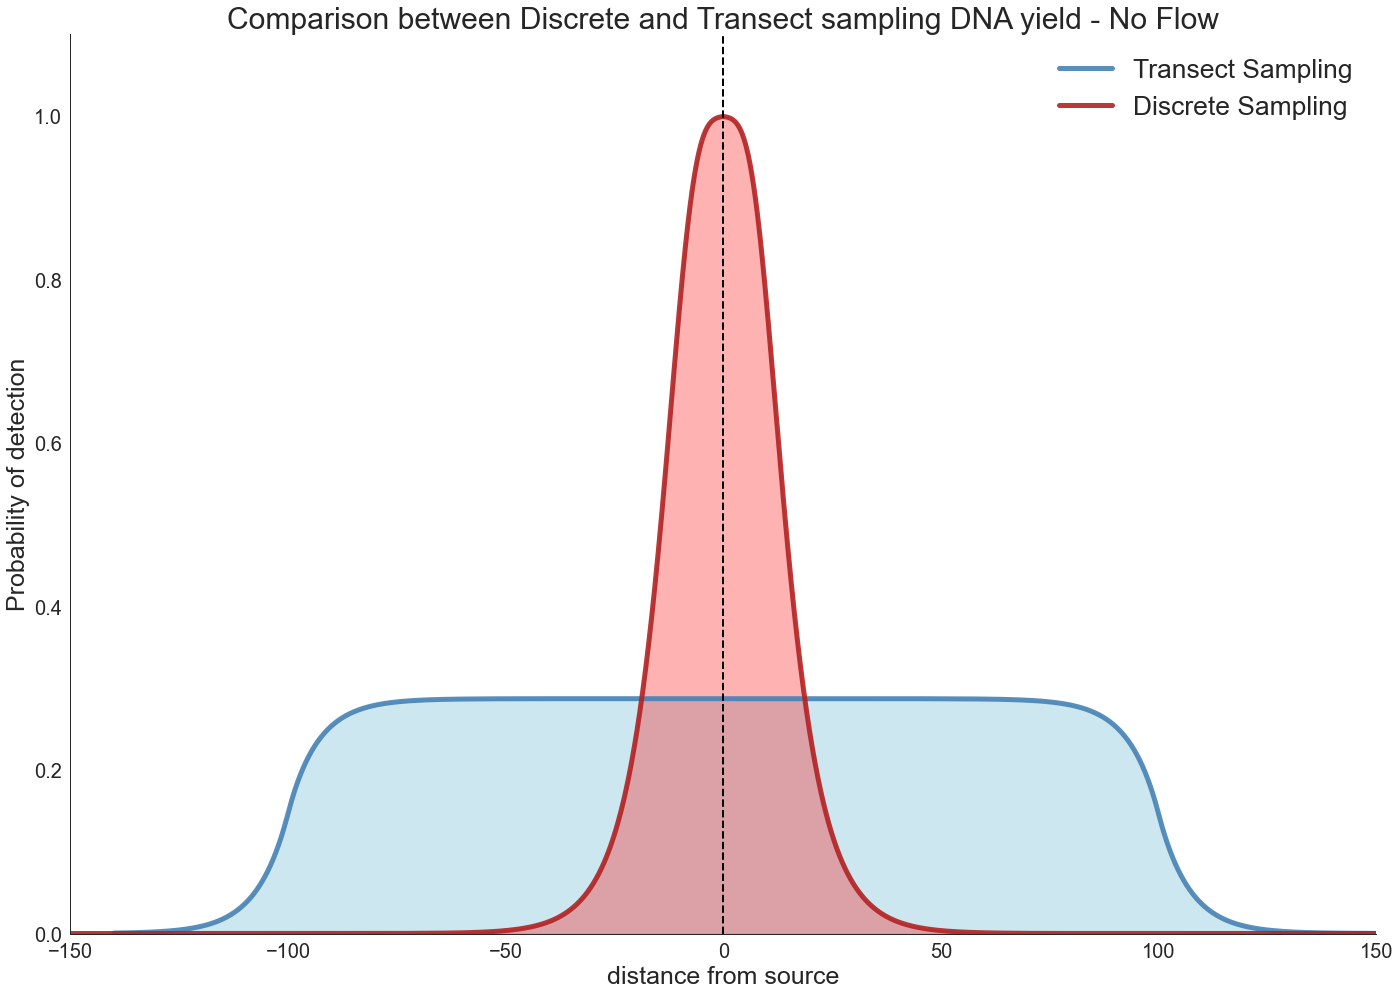

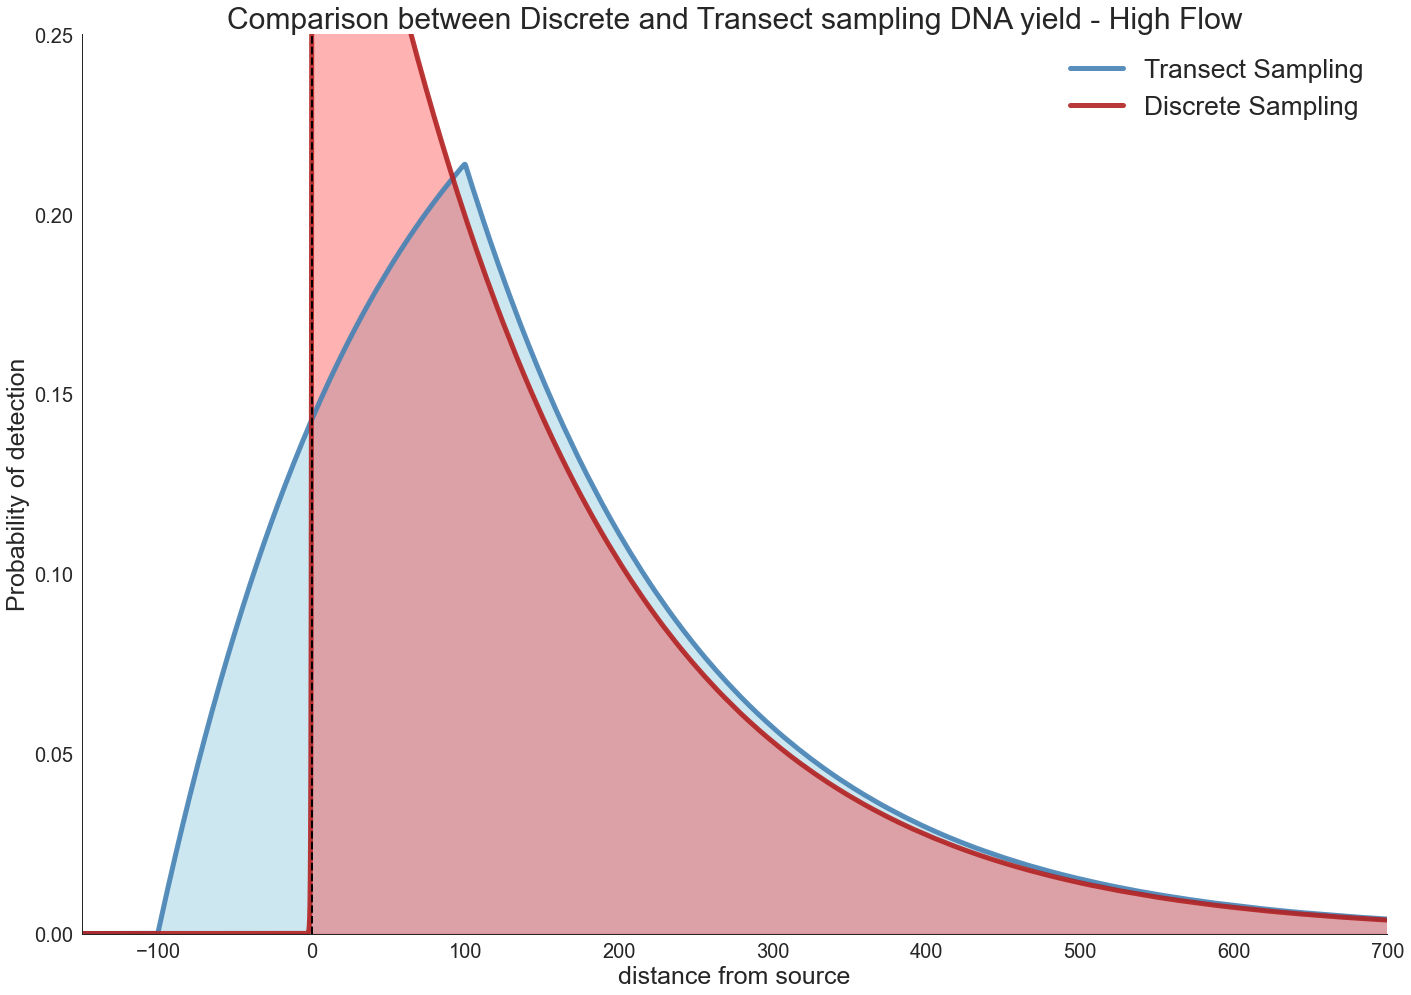

B=1 dist=5 V=0.3 u=166666.66666666666 λ=0.002 D=0.1 H=10 pf=0.005 BV=1e-06 T=600


In [71]:
distlist = [random.random()*100 for i in range(1000)]
river = River()
river.init_fish(dist_bet_fish = 5, biomass = 1)
#river.init_river_params(V =.0, D = 1e-3,u = 2.1*1e5 , λ = 2e-3, H = 10)
river.init_river_params(V =.0, D = 1e-1,u = u , λ = lam, H = 10)

river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1

ranges = np.linspace(-240,240,10000)


river.BV = 1/3
transect = river.CtoP([river.sample_eDNA_transect(x) for x in ranges])
plt.plot(ranges+ river.BV*river.T/2, transect, label = 'Transect Sampling', linewidth = 5, alpha = .9, color = 'steelblue')
plt.fill_between(ranges+ river.BV*river.T/2,transect , 0, 
                 #where = (ranges > -250) & (ranges <= 300), 
                 color = 'lightblue', alpha = .6) 


river.BV = 1e-6
discrete = river.CtoP([river.sample_eDNA_transect(x) for x in ranges])

plt.plot(ranges+ river.BV*river.T/2, discrete, label = 'Discrete Sampling', linewidth = 5, alpha = .9, color = 'firebrick')
plt.axvline(0, linestyle = '--', color = 'black', linewidth = 2)
sns.despine()
plt.ylim([0,1.1])

plt.legend(fontsize = 30, loc = 'upper left')#, title = 'Sampling mode'


plt.xlabel("distance from source",fontsize = 25)
plt.ylabel("Probability of detection",fontsize = 25) #x if x>1  else 1
plt.title('Comparison between Discrete and Transect sampling DNA yield - No Flow')


plt.fill_between(ranges, discrete , 0, 
                 #where = (ranges > -250) & (ranges <= 300), 
                 color = 'red', alpha = .3) 

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlim([-150,150])
plt.legend()
plt.show()


ranges = np.linspace(-1000,1000,50000)


river.V = 0.3

river.BV = 1/3
transect = river.CtoP([river.sample_eDNA_transect(x) for x in ranges])
plt.plot(ranges + river.BV*river.T/2, transect, label = 'Transect Sampling', linewidth = 5, alpha = .9, color = 'steelblue')
plt.fill_between(ranges+ river.BV*river.T/2,transect , 0, 
                 #where = (ranges > -250) & (ranges <= 300), 
                 color = 'lightblue', alpha = .6) 




river.BV = 1e-6
discrete = river.CtoP([river.sample_eDNA_transect(x) for x in ranges])

plt.plot(ranges+ river.BV*river.T/2, discrete, label = 'Discrete Sampling', linewidth = 5, alpha = .9, color = 'firebrick')
plt.axvline(0, linestyle = '--', color = 'black', linewidth = 2)
sns.despine()
plt.ylim([0,.25])

plt.legend(fontsize = 30, loc = 'upper left')#, title = 'Sampling mode'


plt.xlabel("distance from source",fontsize = 25)
plt.ylabel("Probability of detection",fontsize = 25) #x if x>1  else 1
plt.title('Comparison between Discrete and Transect sampling DNA yield - High Flow')


plt.fill_between(ranges+ river.BV*river.T/2, discrete , 0, 
                 #where = (ranges > -250) & (ranges <= 300), 
                 color = 'red', alpha = .3) 

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend()
plt.xlim([-150, 700])
plt.show()
river.print_params()

Optimization terminated successfully.
         Current function value: 0.393247
         Iterations 11


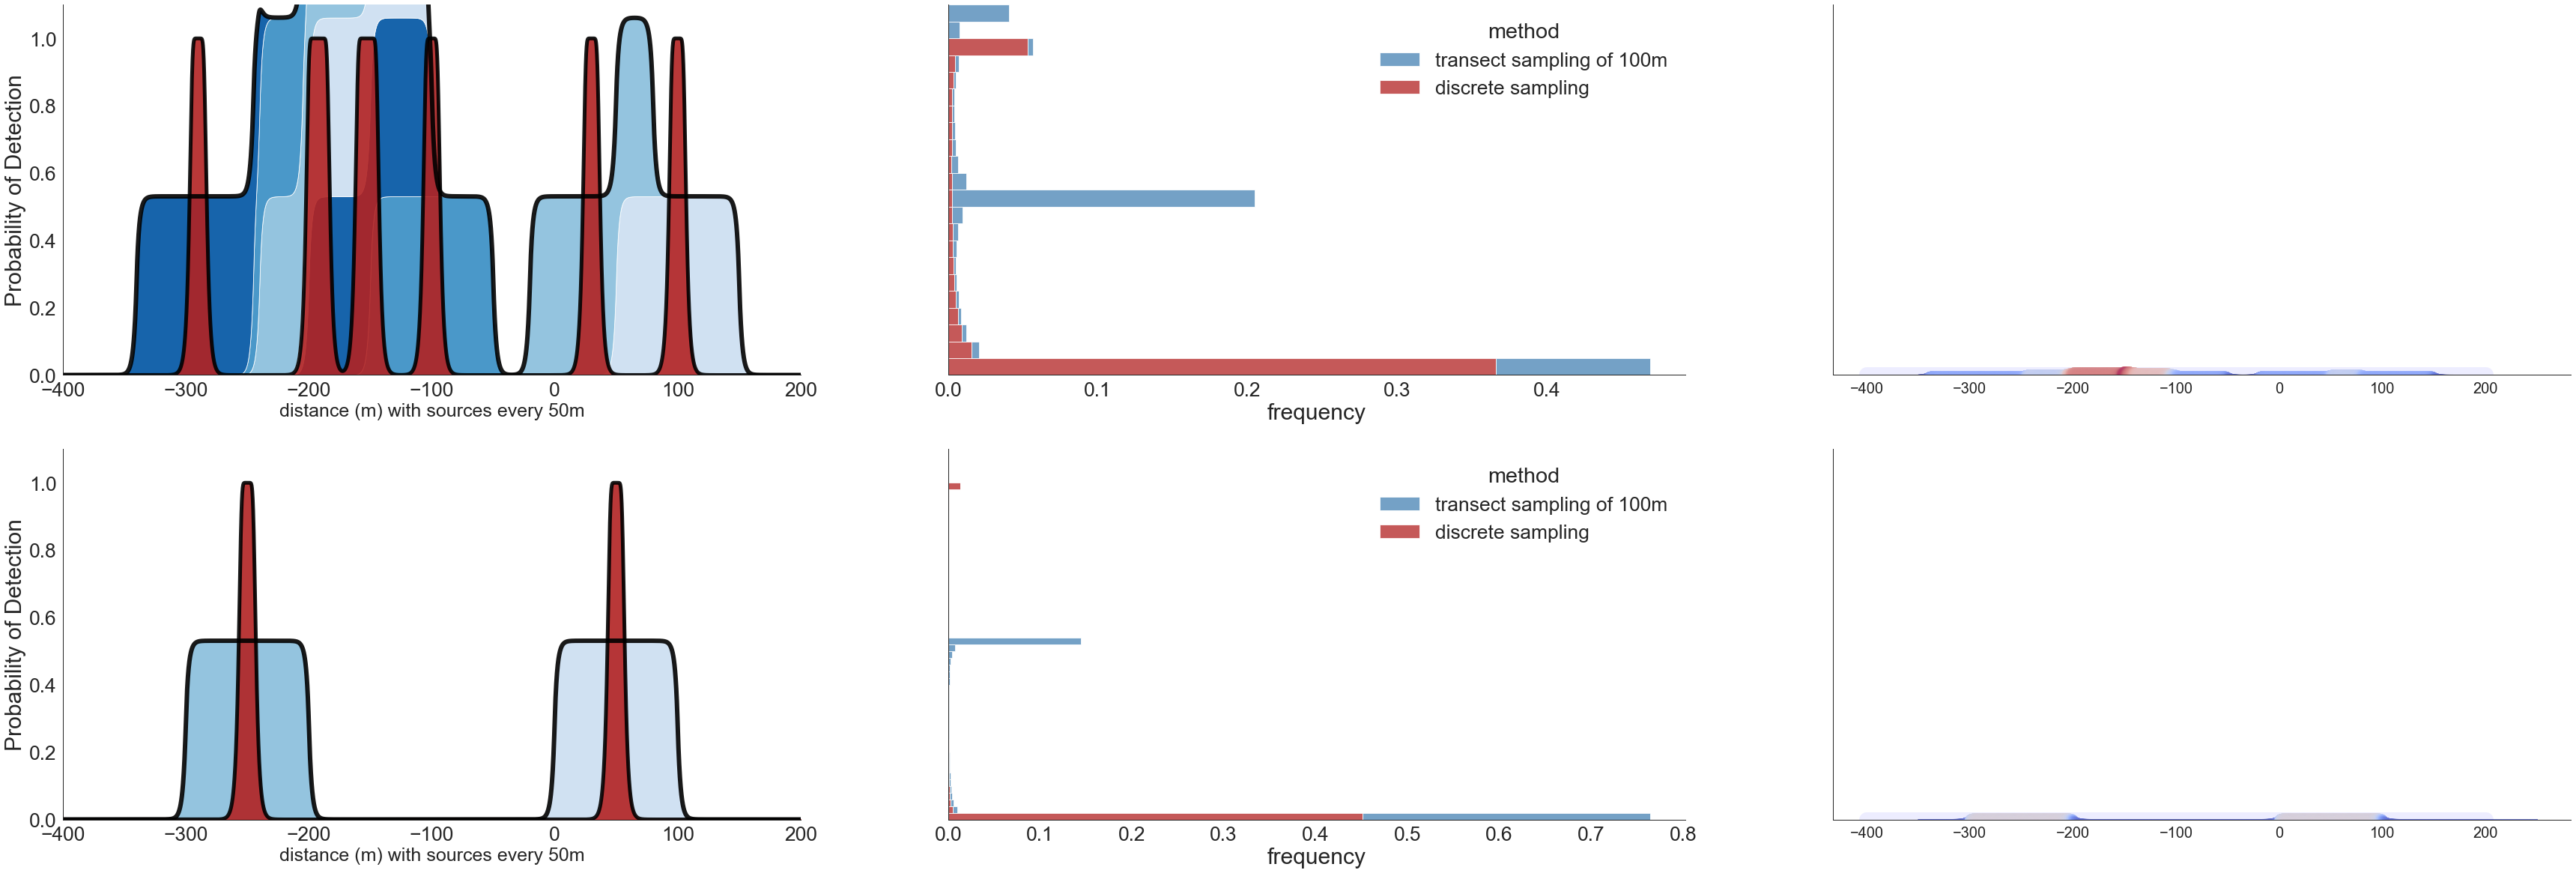

0.1943039949109011 0.14198762587871616


In [61]:
pd.options.mode.chained_assignment = None
river = River()
river.init_fish(dist_bet_fish = 5, biomass = 1)
#river.init_river_params(V =.0, D = 1e-3,u = 2.1*1e5 , λ = 2e-3, H = 10)
river.init_river_params(V =.0, D = D,u = u , λ = lam, H = 10)

river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1


fig, axs = plt.subplots(2, 3, figsize=(60, 20), sharey=True)

def fish_locations(dist):
    x = 0
    returnable = []
    while x > -100 :
        a = -np.random.exponential(dist, 1)[0]
        x += a
        returnable += [x]
    returnable = returnable[::-1]
    x = 0        
    while x < 300:
        a = np.random.exponential(dist, 1)[0]
        x += a
        returnable += [x]
    return returnable

def x2xy(x):
    L = x.max() - x.min()
    R = L/(2*np.pi)
    rg = x + x.min()
    q, r = ([R- R*np.cos(k/R) if np.sin(k/R)>0 else 3*R + R*np.cos(k/R) for k in rg] , R*np.sin(rg/R))
    return (np.array(q),r)

for num, fishcon in enumerate([np.array([-300, -230, -100, -50,-45, -10,-5,90]) +200, np.array([-250, 50])+200]):
    ranges = np.linspace(-600,600,10000)
    fishes = fishcon#fish_locations(45) #range(-1000, 1000, 50)#

    fish_loc = [ ranges + x for x in fishes]  #ranges +
    range_list = [ np.linspace(-240 + x,240 + x,10000) for x in range(-500, 501, 50)]

    river.BV = 1e-5

    discrete1 = river.CtoP(sum([np.array([river.sample_eDNA_transect(x) for x in rg])  for rg in fish_loc]))
    axs[num, 0].plot(ranges + river.BV*river.T/2 , discrete1, label = 'Discrete sampling', linewidth = 5, alpha = .9, color = 'black') #+ river.BV*river.T/2



    river.BV = 100/600


    discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    discrete = sum(discrete_list)
    #discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    axs[num, 0].plot(ranges + river.BV*river.T/2, discrete, label = 'Transect of {:.0f}m'.format(river.BV*river.T), linewidth = 6, alpha = .9, color = 'black') # + river.BV*river.T/2


    axs[num, 0].stackplot(ranges + river.BV*river.T/2 , discrete_list, colors = sns.color_palette("Blues", 4)) # + river.BV*river.T/2



    sns.despine()
    axs[num, 0].set_ylim([0,max(discrete1)*1.1])
    axs[num, 0].set_xlim((-400, 200))

    #plt.legend(fontsize = 30,loc=(1.04,.6))#, title = 'Sampling mode'


    axs[num, 0].set_xlabel("distance (m) with sources every 50m",fontsize = 25)
    axs[num, 0].set_ylabel('Probability of Detection',fontsize = 30)

    #plt.ylabel("Probability of detection",fontsize = 25) #x if x>1  else 1
    plt.title('')


    #plt.fill_between(ranges, discrete , 0, 
    #                 color = 'red', alpha = .3) 

    axs[num, 0].fill_between(ranges, discrete1 , 0, 
                     color = 'firebrick', alpha = .9, label = 'Discrete sampling') 




    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    #plt.legend()
    plt.subplot(2, 3, num*3 + 2)
    plt.ylim([0,max(discrete1)*1.1])

    lg = pd.DataFrame([[x, 'transect sampling of {:.0f}m'.format(river.BV*river.T), pos] for x, pos in zip(discrete, ranges)] + [[x, 'discrete sampling', pos] for x, pos in zip(discrete1, ranges)] ,
                      columns = ['Probability of Detection', 'method', 'position'])

    sns.histplot( hue = 'method', y = 'Probability of Detection',  data = lg.query(' -400 < position < 200 '),multiple="stack",
                 palette =['steelblue', 'firebrick'], stat = 'probability', bins = 50)

    sns.despine()
    plt.xlabel('frequency')

    plt.subplot(2,3, num*3 + 3)
    lgsub = lg.query(' -400 < position < 200 ')
    lgsub.position = lgsub.apply(lambda row: row.position + river.BV*river.T/2 if row.method != "discrete sampling" else row.position, axis =1)
    #lgsub.loc[lgsub.method != 'discrete sampling' , 'position'] += river.BV*river.T/2
    #lgsub['x'], lgsub['y'] = x2xy(lgsub['position'] )
    lgsub['x'], lgsub['y'] = lgsub['position'], 0
    lgsub.y = lgsub.apply(lambda row: row.y + 10 if row.method == "discrete sampling" else row.y, axis = 1)

    #plt.scatter(lgsub.x, lgsub.y, color = 'blue', s = 300)
    plt.plot([-400, 200],[0,0], linewidth = 20, alpha = .07, color = 'blue')
    plt.plot([-400, 200],[10,10], linewidth = 20, alpha = .07, color = 'blue')
    sns.scatterplot(x='x', y='y', hue = 'Probability of Detection', 
                    data = lgsub,palette='coolwarm',
                    size =  'Probability of Detection', sizes = (1,500), alpha = 1) #.query('method == "discrete sampling"')
    plt.legend().set_visible(False)
    sns.despine()
    plt.xlabel(' ')
    plt.ylabel(' ')



plt.show()
print(np.std(discrete), np.std(discrete1))


In [9]:
river.D*river.u/river.H

3904.0118

Optimization terminated successfully.
         Current function value: 0.393247
         Iterations 11


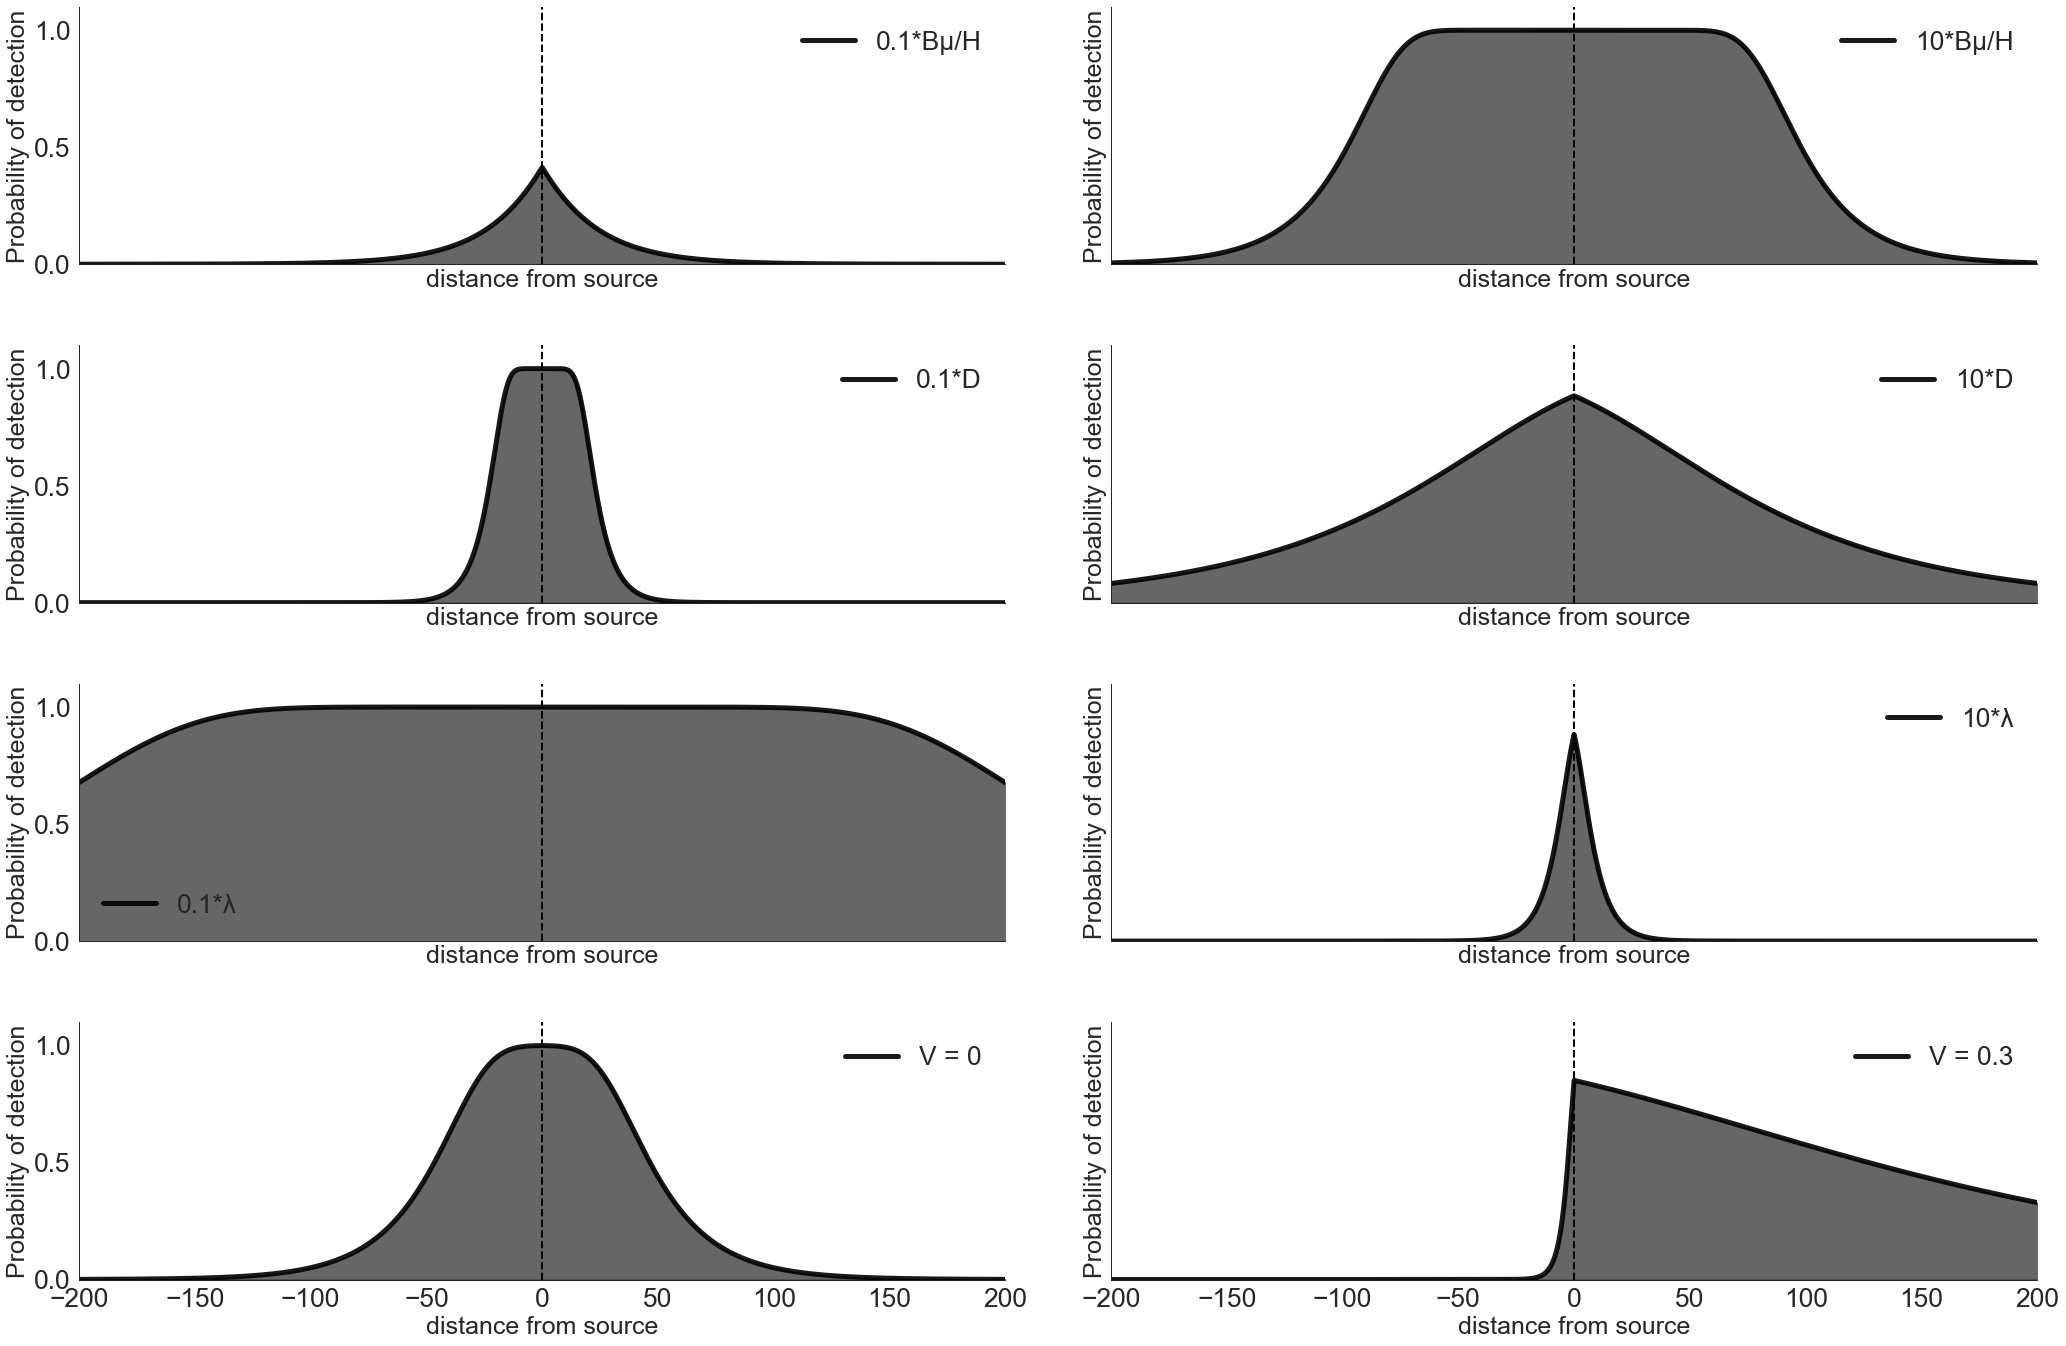

B=1 dist=5 V=0.3 u=1666666.6666666665 λ=0.002 D=1 H=10 pf=0.005 BV=1e-10 T=200


In [80]:
river = River()

ranges = np.linspace(-240,240,10000)
fig, axs = plt.subplots(4, 2, figsize=(30, 20), sharey=True, sharex= True)
for num,i in enumerate([[1,2], [3,4], [5,6], [7, 8]]):
    for num2, j in enumerate(i):
        river.init_fish(dist_bet_fish = 5, biomass = 1)
        #river.init_river_params(V =0.0, D = 1e-3,u = 1e7/60 , λ = 2e-3, H = 50)
        river.init_river_params(V =.0, D = 1,u = 10*u , λ = lam, H = 10)
        #river.init_river_params(V =.0, D = 1e-1,u = u , λ = lam, H = 50)

        river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1e-10, time = 10*20)
        river.error = 1e-1
        
        if num2 == 0:
            if num == 0: 
                river.B *=  .10 
                label = '0.1*Bμ/H'
            if num == 1: 
                river.D *= .10
                label = '0.1*D'
            if num == 2: 
                river.λ *= .1
                label = '0.1*λ'
            if num == 3: 
                river.V = 0.0
                label = 'V = 0'
        
        if num2 == 1:
            if num == 0: 
                river.B *=10 
                label = '10*Bμ/H'
            if num == 1: 
                river.D *= 10
                label = '10*D'
            if num == 2: 
                river.λ *= 10
                label = '10*λ'
            if num == 3: 
                river.V = .3#0.02
                label = 'V = 0.3'
    
        transect = river.CtoP([river.sample_eDNA_transect(x) for x in ranges])
        axs[num, num2].plot(ranges+ river.BV*river.T/2, transect, label = label, linewidth = 5, alpha = .9, color = 'black')
        axs[num, num2].axvline(0, linestyle = '--', color = 'black', linewidth = 2)
        axs[num, num2].fill_between(ranges+ river.BV*river.T/2,transect , 0,   color = 'black', alpha = .6) 
        axs[num, num2].set_xlabel("distance from source",fontsize = 25)
        axs[num, num2].set_ylim([0,1.1])
        axs[num, num2].set_xlim([-200,200])
        axs[num, num2].set_ylabel("Probability of detection",fontsize = 25) 
        axs[num, num2].legend()
        sns.despine()



plt.tight_layout()
plt.savefig('comparision parameters.png', dpi = 200)
plt.show()
river.print_params()


In [11]:
0.005* 200

1.0

In [64]:
river = River()
river.init_fish(dist_bet_fish = 50, biomass = .1)
#river.init_river_params(V =1e-5, D = 1e-3,u = 1e7/60 , λ = 2e-3, H = 50)
river.init_river_params(V =.0, D = D,u = u , λ = lam, H = 10)

river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1e-5, time = 10*60)
river.error = 1e-1

ranges = np.linspace(-600,600,10000)
fishes = range(-1000, 1000, 300)# fish_locations(100) #

fish_loc = [ ranges + x for x in fishes]  #ranges +


def func(tsize):
    river.BV = tsize/600
    a = river.CtoP(sum([np.array([river.sample_eDNA_transect(x) for x in rg])  for rg in fish_loc]))
    return np.std(a)* np.mean(a)

%time stats = {var :func(var) for var in range(5, 60, 5)}
max(stats, key=lambda k: stats[k])

Optimization terminated successfully.
         Current function value: 0.393247
         Iterations 11
Wall time: 6.87 s


5

Optimization terminated successfully.
         Current function value: 0.393247
         Iterations 11


C:\Users\thiag\anaconda3\envs\ednash_nov2021\lib\site-packages\seaborn\_statistics.py:369: RuntimeWarning: invalid value encountered in true_divide
  hist = hist.astype(float) / hist.sum()


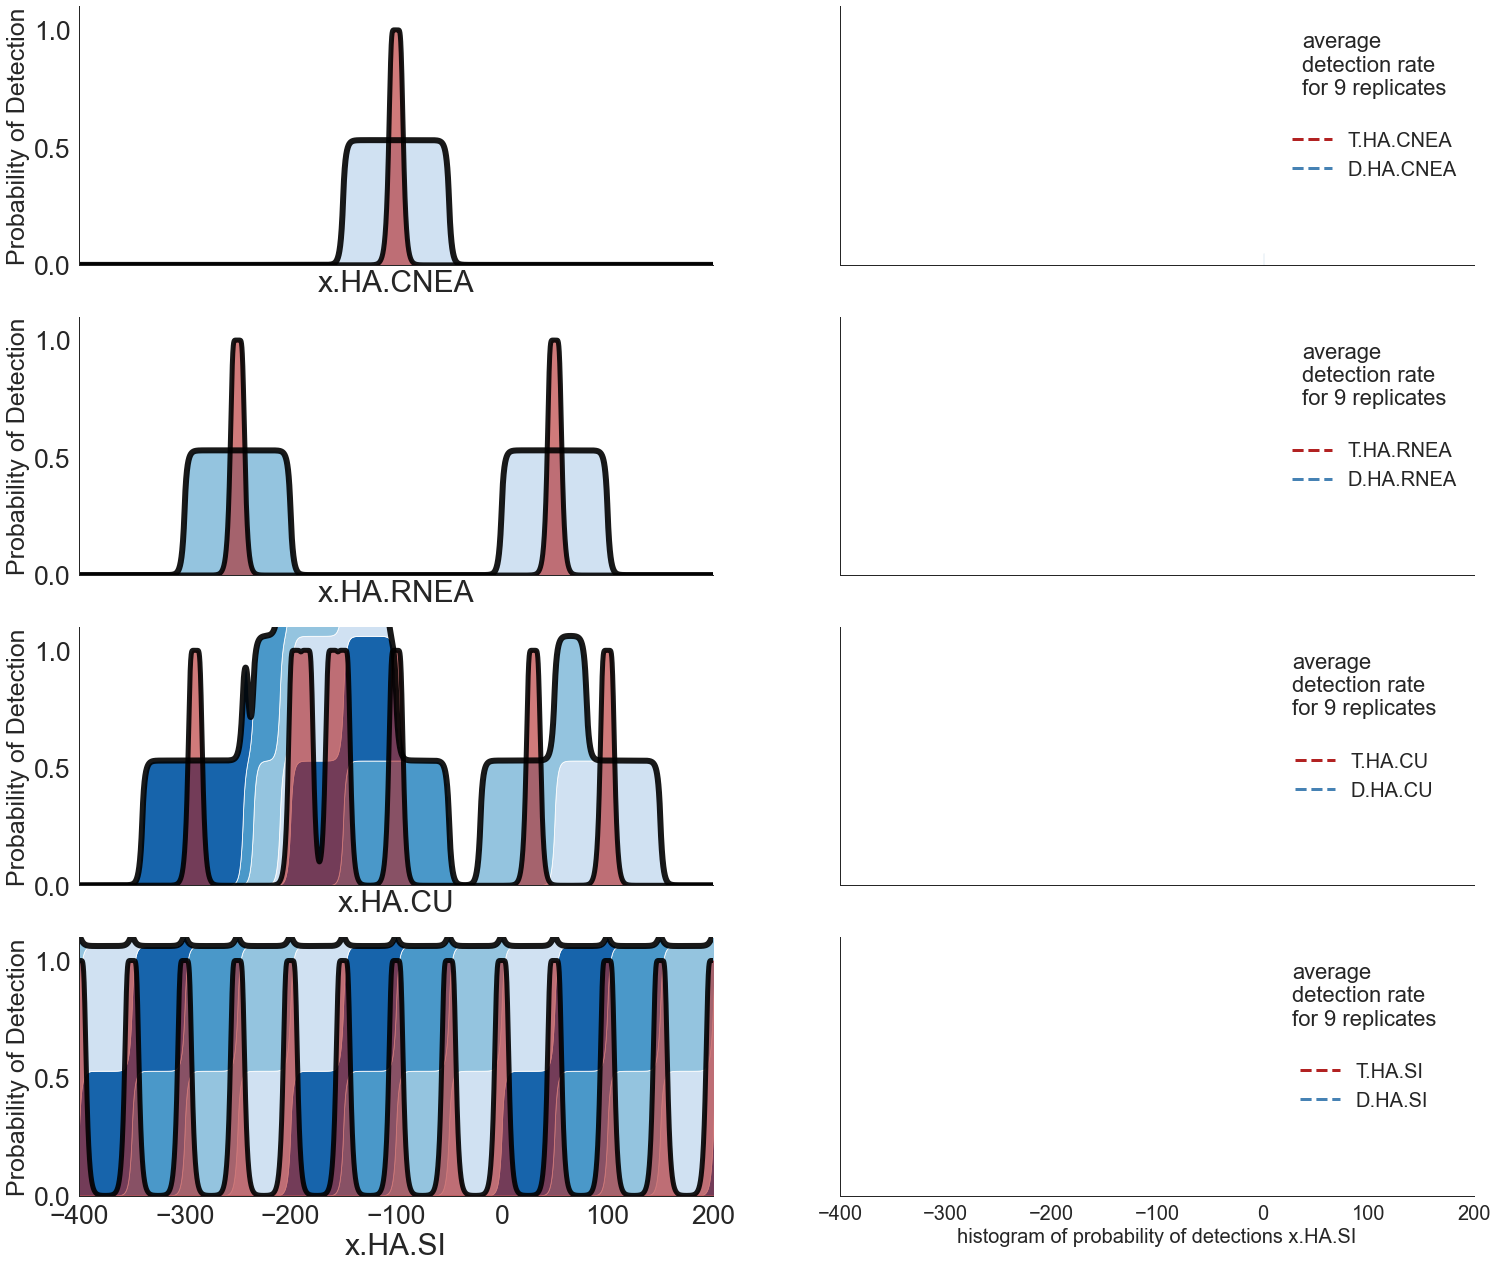

0.10804847817730007 0.3964604866804457


In [65]:
river = River()
river.init_fish(dist_bet_fish = 50, biomass = 1)
#river.init_river_params(V = 0, D = 1e-3,u = 1e7/60 , λ = 2e-3, H = 50)
river.init_river_params(V =.0, D = D,u = u , λ = lam, H = 10)

river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1e-5, time = 10*60)
river.error = 1e-1


fig, axs = plt.subplots(4, 2, figsize=(40/1.6,35/1.6), sharey=True, sharex = True)

def fish_locations(dist):
    x = 0
    returnable = []
    while x > -100 :
        a = -np.random.exponential(dist, 1)[0]
        x += a
        returnable += [x]
    returnable = returnable[::-1]
    x = 0        
    while x < 300:
        a = np.random.exponential(dist, 1)[0]
        x += a
        returnable += [x]
    return returnable

def x2xy(x):
    L = x.max() - x.min()
    R = L/(2*np.pi)
    rg = x + x.min()
    q, r = ([R- R*np.cos(k/R) if np.sin(k/R)>0 else 3*R + R*np.cos(k/R) for k in rg] , R*np.sin(rg/R))
    return (np.array(q),r)

for num, fishcon in enumerate([[100], np.array([-250, 50])+200, np.array([-300, -230, -100, -50,-40, -15,-5,90]) +200, np.array(range(-800, 800, 50)) +200 ]):
    n = 9
    ranges = np.linspace(-600,600,10000)
    fishes = fishcon#fish_locations(45) #range(-1000, 1000, 50)#

    fish_loc = [ ranges + x for x in fishes]  #ranges +
    range_list = [ np.linspace(-240 + x,240 + x,10000) for x in range(-500, 501, 50)]

    river.BV = 1e-5

    discrete1 = river.CtoP(sum([np.array([river.sample_eDNA_transect(x) for x in rg])  for rg in fish_loc]))
    axs[num, 0].plot(ranges + river.BV*river.T/2 , discrete1, label = 'Discrete sampling', linewidth = 5, alpha = .9, color = 'black') #+ river.BV*river.T/2



    river.BV = 100/600


    discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    discrete = sum(discrete_list)
    #discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    axs[num, 0].plot(ranges + river.BV*river.T/2, discrete, label = 'Transect of {:.0f}m'.format(river.BV*river.T), linewidth = 6, alpha = .9, color = 'black') # + river.BV*river.T/2
    axs[num, 0].stackplot(ranges + river.BV*river.T/2 , discrete_list, colors = sns.color_palette("Blues", 4)) # + river.BV*river.T/2
    sns.despine()
    axs[num, 0].set_ylim([0,1])
    axs[num, 0].set_xlim((-400, 200))

    #plt.legend(fontsize = 30,loc=(1.04,.6))#, title = 'Sampling mode'

    if num == 0:case = 'x.HA.CNEA'
    if num == 1:case = 'x.HA.RNEA'
    if num == 2:case = 'x.HA.CU'
    if num == 3:case = 'x.HA.SI'
    axs[num, 0].set_xlabel(case,fontsize = 30)
    axs[num, 0].set_ylabel('Probability of Detection',fontsize = 25)

    plt.title('')


    lg = pd.DataFrame([[x, 'transect sampling of {:.0f}m'.format(river.BV*river.T), pos] for x, pos in zip(discrete, ranges)] + [[x, 'discrete sampling', pos] for x, pos in zip(discrete1, ranges)] ,
                      columns = ['Probability of Detection', 'method', 'position'])

    axs[num, 0].fill_between(ranges, discrete1 , 0, 
                     color = 'firebrick', alpha = .6, label = 'Discrete sampling') 

    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    #plt.legend()
    plt.subplot(4, 2, num*2 + 2)
    plt.ylim([0,max(discrete1)*1.1])

    lg = pd.DataFrame([[x, 'transect sampling of {:.0f}m'.format(river.BV*river.T), pos] for x, pos in zip(discrete, ranges)] + [[x, 'discrete sampling', pos] for x, pos in zip(discrete1, ranges)] ,
                      columns = ['Probability of Detection', 'method', 'position'])

    sns.histplot( hue = 'method', y = 'Probability of Detection',  data = lg.query(' -400 < position < 200 '),multiple="stack",
                 palette =['steelblue', 'firebrick'], stat = 'probability', bins = 20, binrange = [0,1])
    sns.despine()
    plt.hlines(y = (1- (1-lg.query(' -400 < position < 200 and method == "discrete sampling"')['Probability of Detection'])**n).mean(), 
               xmin = 0, xmax = 0.3,color = 'firebrick',linewidth = 3, linestyle = 'dashed', label = "T"+case[case.find('.'):])
    plt.hlines(y = (1-(1- lg.query(' -400 < position < 200 and method != "discrete sampling"')['Probability of Detection'])**n).mean(), 
               xmin = 0, xmax = 0.3,color = 'steelblue', linewidth = 3,linestyle = 'dashed', label = "D"+case[case.find('.'):] )
    plt.xlabel('histogram of probability of detections '+ case, fontsize=20 )
    #plt.ylim([0,.9])
    plt.ylabel('Probability of Detection',fontsize = 25)
    plt.legend(loc=(.7,.3), title="average\ndetection rate\nfor {0:0d} replicates\n".format(n), fontsize=20, title_fontsize = 22 )


plt.show()
print(np.std(discrete), np.std(discrete1))


Optimization terminated successfully.
         Current function value: 0.393247
         Iterations 11


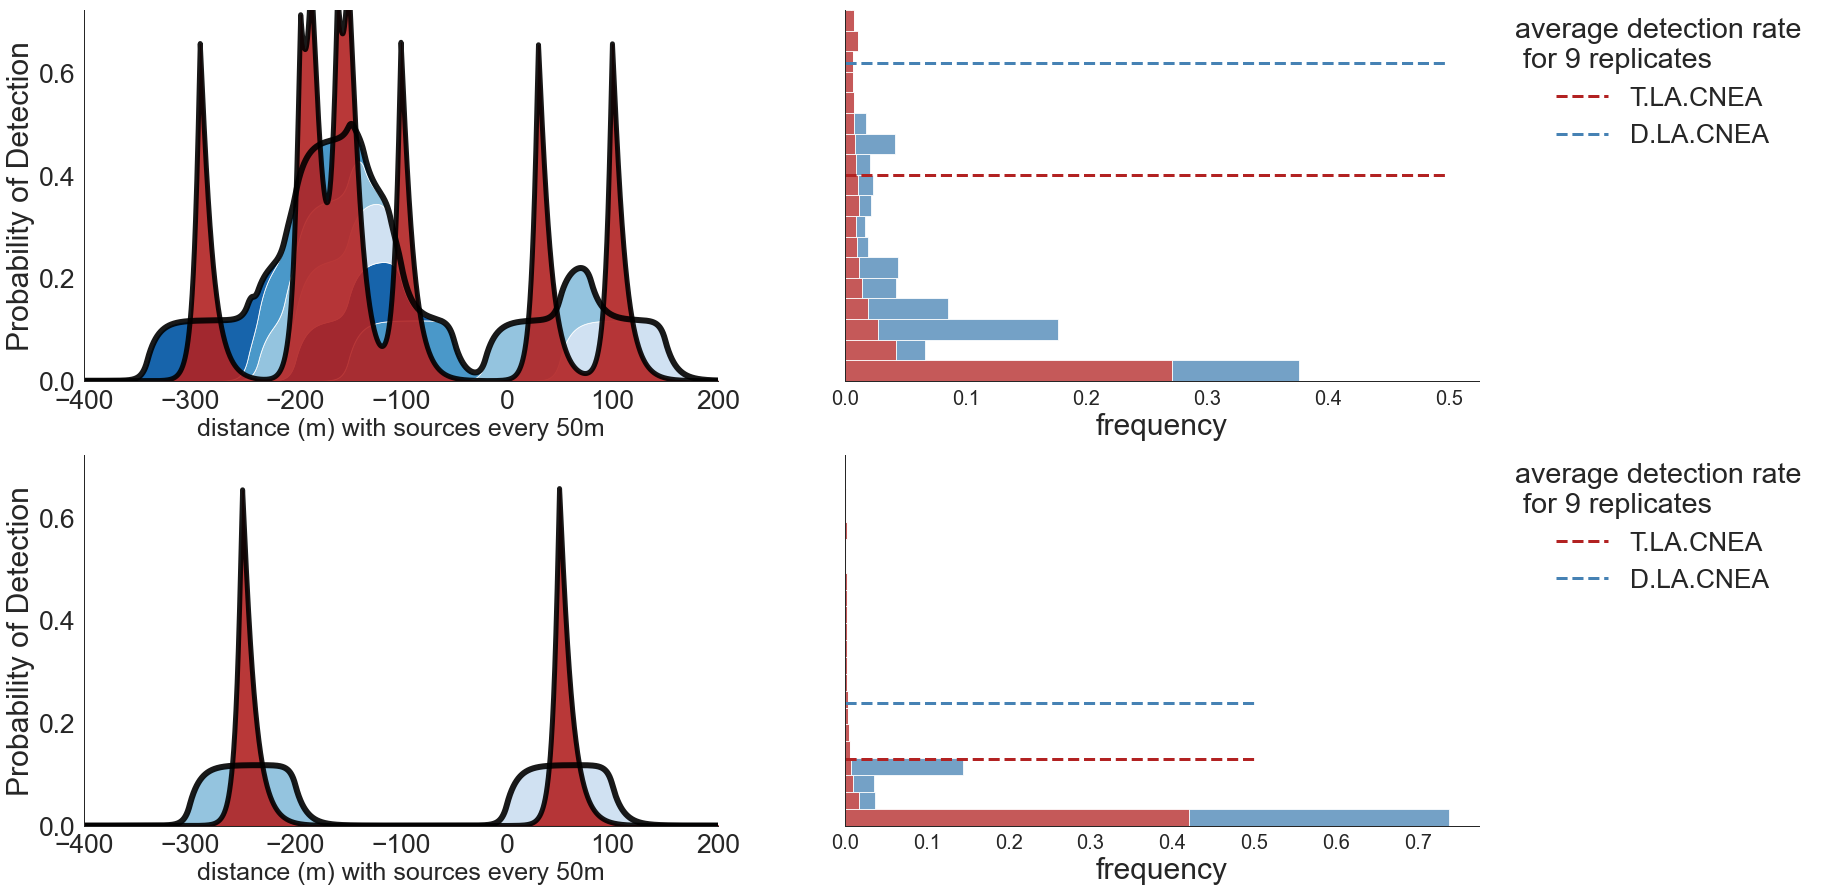

0.040694408212257435 0.07822694039113712


In [68]:
river = River()
river.init_fish(dist_bet_fish = 50, biomass = 1)
river.init_river_params(V = .01, D = 1e-1,u = 1e7/60 , λ = 2e-3, H = 50)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1e-5, time = 10*60)
river.error = 1e-1


fig, axs = plt.subplots(2, 2, figsize=(25, 15), sharey=True)

def fish_locations(dist):
    x = 0
    returnable = []
    while x > -100 :
        a = -np.random.exponential(dist, 1)[0]
        x += a
        returnable += [x]
    returnable = returnable[::-1]
    x = 0        
    while x < 300:
        a = np.random.exponential(dist, 1)[0]
        x += a
        returnable += [x]
    return returnable

def x2xy(x):
    L = x.max() - x.min()
    R = L/(2*np.pi)
    rg = x + x.min()
    q, r = ([R- R*np.cos(k/R) if np.sin(k/R)>0 else 3*R + R*np.cos(k/R) for k in rg] , R*np.sin(rg/R))
    return (np.array(q),r)

for num, fishcon in enumerate([np.array([-300, -230, -100, -50,-40, -15,-5,90]) +200, np.array([-250, 50])+200]):
    ranges = np.linspace(-600,600,10000)
    fishes = fishcon#fish_locations(45) #range(-1000, 1000, 50)#

    fish_loc = [ ranges + x for x in fishes]  #ranges +
    range_list = [ np.linspace(-240 + x,240 + x,10000) for x in range(-500, 501, 50)]

    river.BV = 1e-5

    discrete1 = river.CtoP(sum([np.array([river.sample_eDNA_transect(x) for x in rg])  for rg in fish_loc]))
    axs[num, 0].plot(ranges + river.BV*river.T/2 , discrete1, label = 'Discrete sampling', linewidth = 5, alpha = .9, color = 'black') #+ river.BV*river.T/2



    river.BV = 100/600


    discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    discrete = sum(discrete_list)
    #discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    axs[num, 0].plot(ranges + river.BV*river.T/2, discrete, label = 'Transect of {:.0f}m'.format(river.BV*river.T), linewidth = 6, alpha = .9, color = 'black') # + river.BV*river.T/2


    axs[num, 0].stackplot(ranges + river.BV*river.T/2 , discrete_list, colors = sns.color_palette("Blues", 4)) # + river.BV*river.T/2



    sns.despine()
    axs[num, 0].set_ylim([0,max(discrete1)*1.1])
    axs[num, 0].set_xlim((-400, 200))

    #plt.legend(fontsize = 30,loc=(1.04,.6))#, title = 'Sampling mode'


    axs[num, 0].set_xlabel("distance (m) with sources every 50m",fontsize = 25)
    axs[num, 0].set_ylabel('Probability of Detection',fontsize = 30)

    #plt.ylabel("Probability of detection",fontsize = 25) #x if x>1  else 1
    plt.title('')


    #plt.fill_between(ranges, discrete , 0, 
    #                 color = 'red', alpha = .3) 

    axs[num, 0].fill_between(ranges, discrete1 , 0, 
                     color = 'firebrick', alpha = .9, label = 'Discrete sampling') 




    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    #plt.legend()
    plt.subplot(2, 2, num*2 + 2)
    plt.ylim([0,max(discrete1)*1.1])

    lg = pd.DataFrame([[x, 'transect sampling of {:.0f}m'.format(river.BV*river.T), pos] for x, pos in zip(discrete, ranges)] + [[x, 'discrete sampling', pos] for x, pos in zip(discrete1, ranges)] ,
                      columns = ['Probability of Detection', 'method', 'position'])

    sns.histplot( hue = 'method', y = 'Probability of Detection',  data = lg.query(' -400 < position < 200 '),multiple="stack",
                 palette =['steelblue', 'firebrick'], stat = 'probability', bins = 20)

    sns.despine()
    n = 9
    plt.hlines(y = (1- (1-lg.query(' -400 < position < 200 and method == "discrete sampling"')['Probability of Detection'])**n).mean(), 
               xmin = 0, xmax = 0.5,color = 'firebrick',linewidth = 3, linestyle = 'dashed', label = "T.LA.CNEA".format(n) )
    plt.hlines(y = (1-(1- lg.query(' -400 < position < 200 and method != "discrete sampling"')['Probability of Detection'])**n).mean(), 
               xmin = 0, xmax = 0.5,color = 'steelblue', linewidth = 3,linestyle = 'dashed', label = "D.LA.CNEA".format(n) )
    plt.xlabel('frequency')
    plt.legend(loc=(1.04,.6), title="average detection rate \n for {0:0d} replicates".format(n))




plt.show()
print(np.std(discrete), np.std(discrete1))


In [42]:
#lgsub['x'], lgsub['y'] = x2xy(lgsub['position'])

#lgsub.y = lgsub.apply(lambda row: row.y + 400 if row.method == "discrete sampling" else row.y, axis = 1)


In [43]:
#sns.histplot(x= 'x', y='y', hue = 'Probability of Detection', 
#                data = lgsub,palette='coolwarm',pthresh=.01 ,alpha = 1, bins = 100) #.query('method == "discrete sampling"')
#sns.despine()

Optimization terminated successfully.
         Current function value: 0.393247
         Iterations 11
B=1 dist=50 V=0.3 u=166666.66666666666 λ=0.002 D=0.1 H=10 pf=0.005 BV=1e-05 T=200


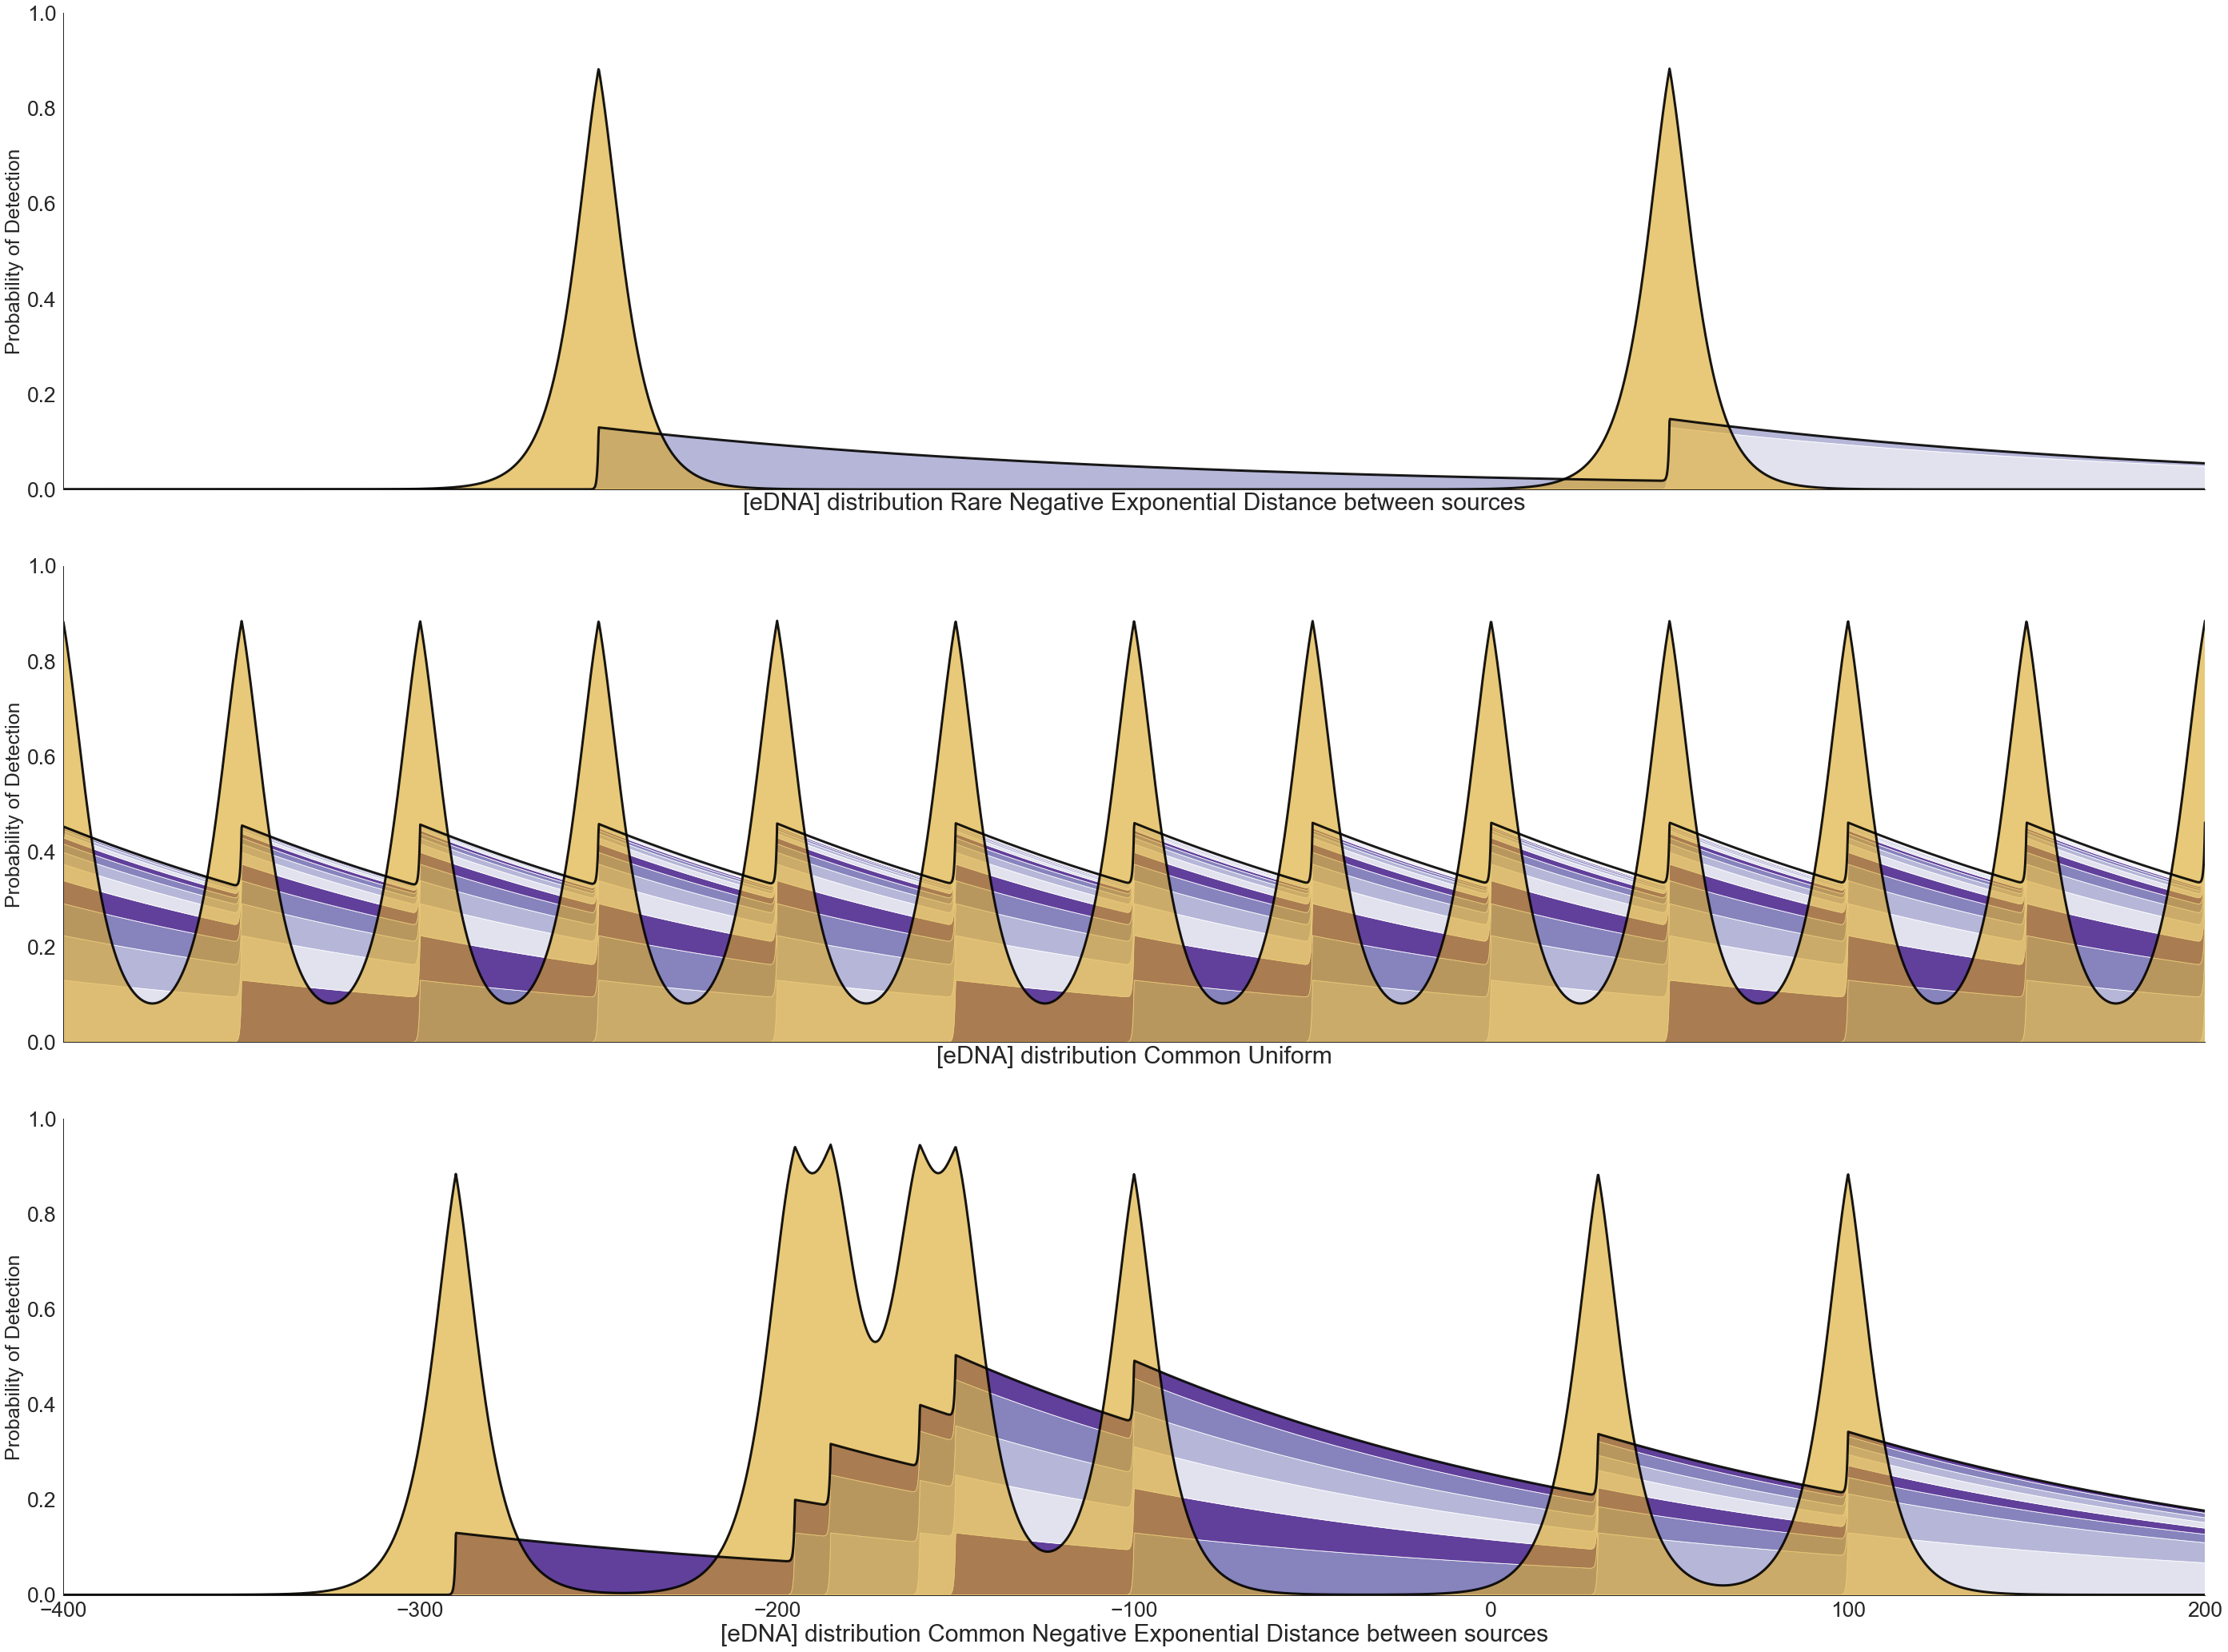

0.13906307604053017 0.22823553532051172


In [69]:
river = River()
river.init_fish(dist_bet_fish = 50, biomass = 1)
#river.init_river_params(V = 0, D = 1e-3,u = 1e7/60 , λ = 2e-3, H = 50)
river.init_river_params(V =.0, D = 1e-1,u = u , λ = lam, H = 10)

river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1e-5, time = 10*20)
river.error = 1e-1


fig, axs = plt.subplots(3, 1, figsize=(40,30), sharey=True, sharex = True)


for num, fishcon in enumerate([ np.array([-250, 50])+200,np.array(range(-800, 800, 50)) +200,np.array([-300, -230, -100, -50,-40, -15,-5,90]) +200]):
    n = 9
    ranges = np.linspace(-600,600,10000)
    fishes = fishcon

    fish_loc = [ ranges + x for x in fishes]  #ranges +
    range_list = [ np.linspace(-240 + x,240 + x,10000) for x in range(-500, 501, 50)]

    river.V = 0

    discrete1 = river.CtoP(sum([np.array([river.CeDNA_1_Source(x) for x in rg])  for rg in fish_loc]))
    axs[num].plot(ranges + river.BV*river.T/2 , discrete1, label = 'Discrete sampling', linewidth = 3, alpha = .9, color = 'black') #+ river.BV*river.T/2



    river.V = .3


    discrete_list = [river.CtoP(np.array([river.CeDNA_1_Source(x) for x in rg]))  for rg in fish_loc]
    discrete = sum(discrete_list)
    #discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    axs[num].plot(ranges + river.BV*river.T/2, discrete, label = 'Transect of {:.0f}m'.format(river.BV*river.T), linewidth = 3, alpha = .9, color = 'black') # + river.BV*river.T/2


    axs[num].stackplot(ranges + river.BV*river.T/2 , discrete_list, colors = sns.color_palette("Purples", 4)) # + river.BV*river.T/2



    sns.despine()
    axs[num].set_ylim([0,1])
    axs[num].set_xlim((-400,200))

    #plt.legend(fontsize = 30,loc=(1.04,.6))#, title = 'Sampling mode'

    if num == 1:case = '[eDNA] distribution Common Uniform'
    if num == 0:case = '[eDNA] distribution Rare Negative Exponential Distance between sources'
    if num == 2:case = '[eDNA] distribution Common Negative Exponential Distance between sources'
    if num == 3:case = 'x.HA.SI'
    axs[num].set_xlabel(case,fontsize = 30)
    axs[num].set_ylabel('Probability of Detection',fontsize = 25)

    #plt.ylabel("Probability of detection",fontsize = 25) #x if x>1  else 1
    plt.title('')


    #plt.fill_between(ranges, discrete , 0, 
    #                 color = 'red', alpha = .3) 
    lg = pd.DataFrame([[x, 'transect sampling of {:.0f}m'.format(river.BV*river.T), pos] for x, pos in zip(discrete, ranges)] + [[x, 'discrete sampling', pos] for x, pos in zip(discrete1, ranges)] ,
                      columns = ['Probability of Detection', 'method', 'position'])

    axs[num].fill_between(ranges, discrete1 , 0, 
                     color = 'goldenrod', alpha = .6, label = 'Discrete sampling') 
    #axs.axhline(y = (1- (1-lg.query(' -400 < position < 200 and method == "discrete sampling"')['Probability of Detection'])**n).mean(), 
               #xmin = -200, xmax = 400,color = 'firebrick',linewidth = 3, linestyle = 'dashed', label = "T.LA.CNEA".format(n) )
    #axs.axhline(y = (1-(1- lg.query(' -400 < position < 200 and method != "discrete sampling"')['Probability of Detection'])**n).mean(), 
               #xmin = -200, xmax = 400,color = 'steelblue', linewidth = 3,linestyle = 'dashed', label = "D.LA.CNEA".format(n) )



plt.tight_layout()
plt.savefig('eDNA distribution several conditions.png', dpi = 100)
river.print_params()
plt.show()
print(np.std(discrete), np.std(discrete1))


Optimization terminated successfully.
         Current function value: 0.393247
         Iterations 11
B=0.8 dist=50 V=0.1 u=166666.66666666666 λ=0.002 D=0.1 H=50 pf=0.005 BV=0.16666666666666666 T=600


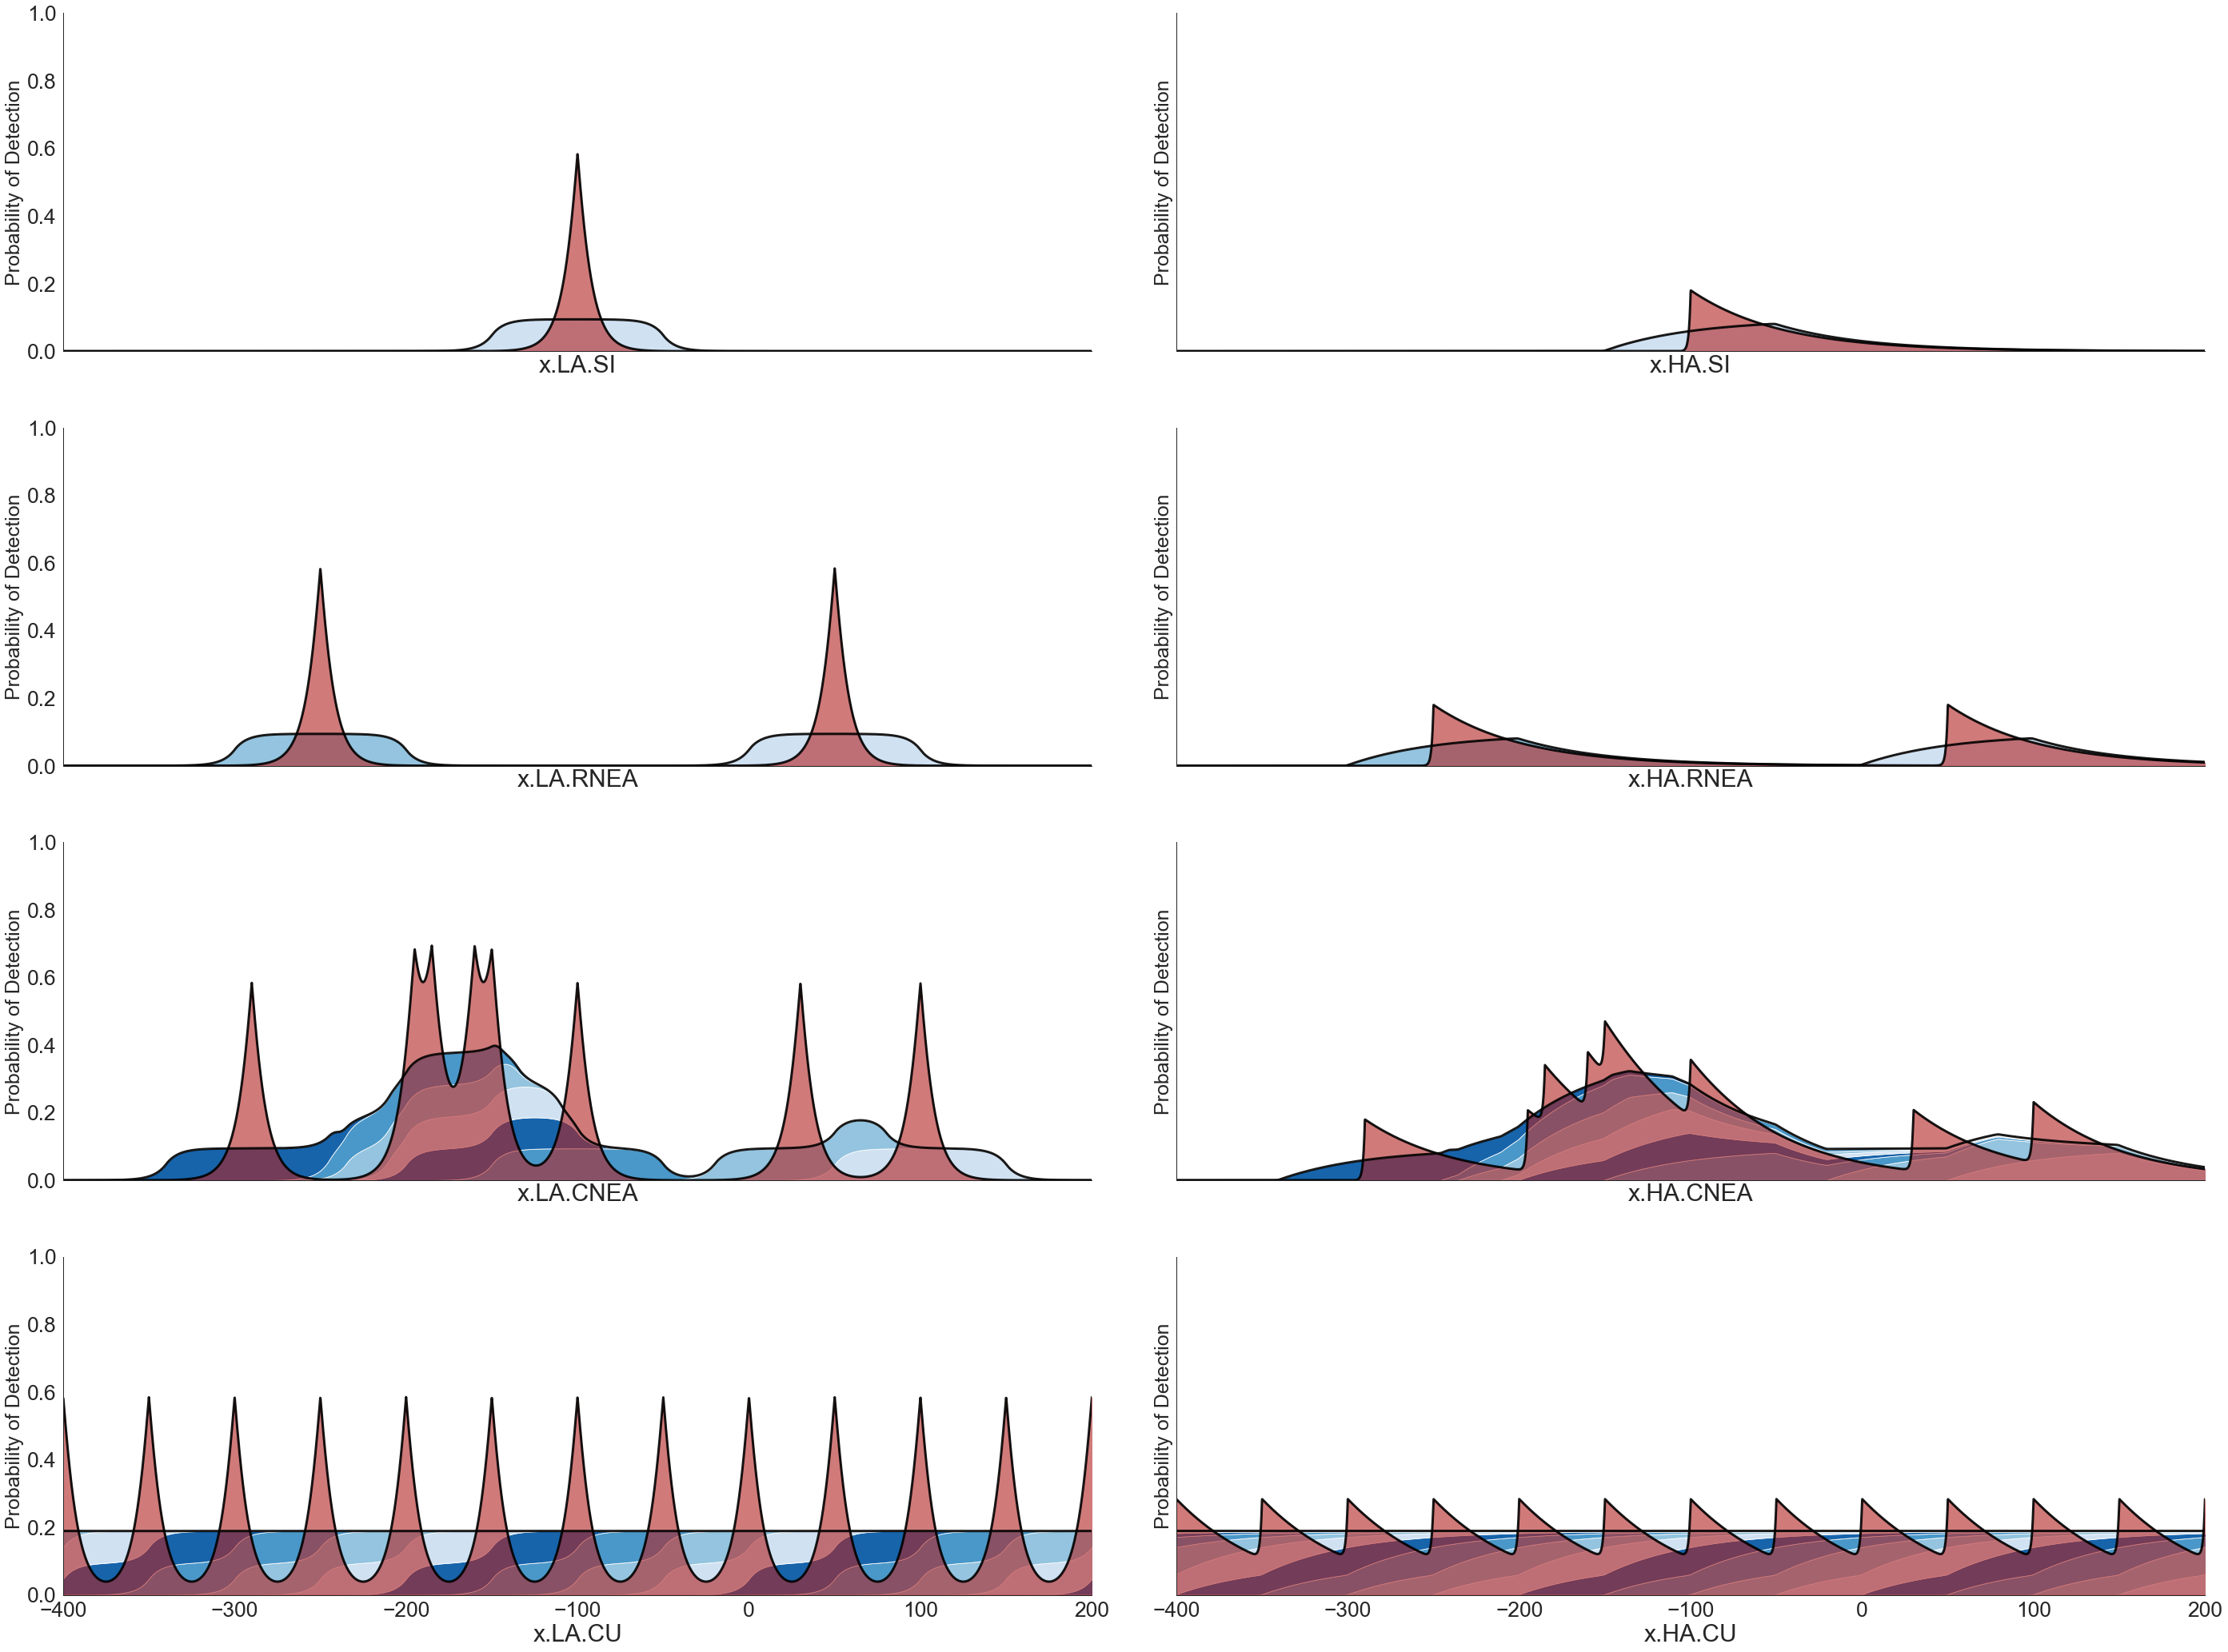

0.007870335328765053 0.048033057255056515


In [70]:
river = River()
river.init_fish(dist_bet_fish = 50, biomass = .8)
river.init_river_params(V = 0, D = 1e-1,u = 1e7/60 , λ = 2e-3, H = 50)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1e-5, time = 10*60)
river.error = 1e-1


fig, axs = plt.subplots(4, 2, figsize=(40,30), sharey=True, sharex = True)

def fish_locations(dist):
    x = 0
    returnable = []
    while x > -100 :
        a = -np.random.exponential(dist, 1)[0]
        x += a
        returnable += [x]
    returnable = returnable[::-1]
    x = 0        
    while x < 300:
        a = np.random.exponential(dist, 1)[0]
        x += a
        returnable += [x]
    return returnable

def x2xy(x):
    L = x.max() - x.min()
    R = L/(2*np.pi)
    rg = x + x.min()
    q, r = ([R- R*np.cos(k/R) if np.sin(k/R)>0 else 3*R + R*np.cos(k/R) for k in rg] , R*np.sin(rg/R))
    return (np.array(q),r)

for num, fishcon in enumerate([[100], np.array([-250, 50])+200, np.array([-300, -230, -100, -50,-40, -15,-5,90]) +200, np.array(range(-800, 800, 50)) +200 ]):
    n = 9
    ranges = np.linspace(-600,600,10000)
    fishes = fishcon#fish_locations(45) #range(-1000, 1000, 50)#

    fish_loc = [ ranges + x for x in fishes]  #ranges +
    range_list = [ np.linspace(-240 + x,240 + x,10000) for x in range(-500, 501, 50)]
    river.V = 0
    river.BV = 1e-5

    discrete1 = river.CtoP(sum([np.array([river.sample_eDNA_transect(x) for x in rg])  for rg in fish_loc]))
    axs[num, 0].plot(ranges + river.BV*river.T/2 , discrete1, label = 'Discrete sampling', linewidth = 3, alpha = .9, color = 'black') #+ river.BV*river.T/2

    river.BV = 100/600

    discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    discrete = [1 if x> 1 else x for x in sum(discrete_list)]
    #discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    axs[num, 0].plot(ranges + river.BV*river.T/2, discrete, label = 'Transect of {:.0f}m'.format(river.BV*river.T), linewidth = 3, alpha = .9, color = 'black') # + river.BV*river.T/2
    axs[num, 0].stackplot(ranges + river.BV*river.T/2 , discrete_list, colors = sns.color_palette("Blues", 4)) # + river.BV*river.T/2
    sns.despine()
    axs[num, 0].set_ylim([0,1])
    axs[num, 0].set_xlim((-400, 200))

    #plt.legend(fontsize = 30,loc=(1.04,.6))#, title = 'Sampling mode'

    if num == 0:case = 'x.LA.SI'
    if num == 1:case = 'x.LA.RNEA'
    if num == 2:case = 'x.LA.CNEA'
    if num == 3:case = 'x.LA.CU'
    axs[num, 0].set_xlabel(case,fontsize = 30)
    axs[num, 0].set_ylabel('Probability of Detection',fontsize = 25)
    axs[num, 0].fill_between(ranges, discrete1 , 0, 
                     color = 'firebrick', alpha = .6, label = 'Discrete sampling') 
    
    river.V = 0.1
    river.BV = 1e-5

    discrete1 = river.CtoP(sum([np.array([river.sample_eDNA_transect(x) for x in rg])  for rg in fish_loc]))
    axs[num, 1].plot(ranges + river.BV*river.T/2 , discrete1, label = 'Discrete sampling', linewidth = 3, alpha = .9, color = 'black') #+ river.BV*river.T/2

    river.BV = 100/600

    discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    discrete = [1 if x> 1 else x for x in sum(discrete_list)]
    #discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    axs[num, 1].plot(ranges + river.BV*river.T/2, discrete, label = 'Transect of {:.0f}m'.format(river.BV*river.T), linewidth = 3, alpha = .9, color = 'black') # + river.BV*river.T/2
    axs[num, 1].stackplot(ranges + river.BV*river.T/2 , discrete_list, colors = sns.color_palette("Blues", 4)) # + river.BV*river.T/2
    sns.despine()
    axs[num, 1].set_ylim([0,1.0])
    axs[num, 1].set_xlim((-400, 200))

    #plt.legend(fontsize = 30,loc=(1.04,.6))#, title = 'Sampling mode'

    if num == 0:case = 'x.HA.SI'
    if num == 1:case = 'x.HA.RNEA'
    if num == 2:case = 'x.HA.CNEA'
    if num == 3:case = 'x.HA.CU'
    axs[num, 1].set_xlabel(case,fontsize = 30)
    axs[num, 1].set_ylabel('Probability of Detection',fontsize = 25)
    axs[num, 1].fill_between(ranges, discrete1 , 0, 
                     color = 'firebrick', alpha = .6, label = 'Discrete sampling') 

    
    
    
    
    

plt.tight_layout()
river.print_params()
plt.savefig('allconditions_transect vs discrete.png')
plt.show()
print(np.std(discrete), np.std(discrete1))

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17
B=0.8 dist=50 V=0.1 u=166666.66666666666 λ=0.002 D=0.001 H=50 pf=0.005 BV=0.16666666666666666 T=600


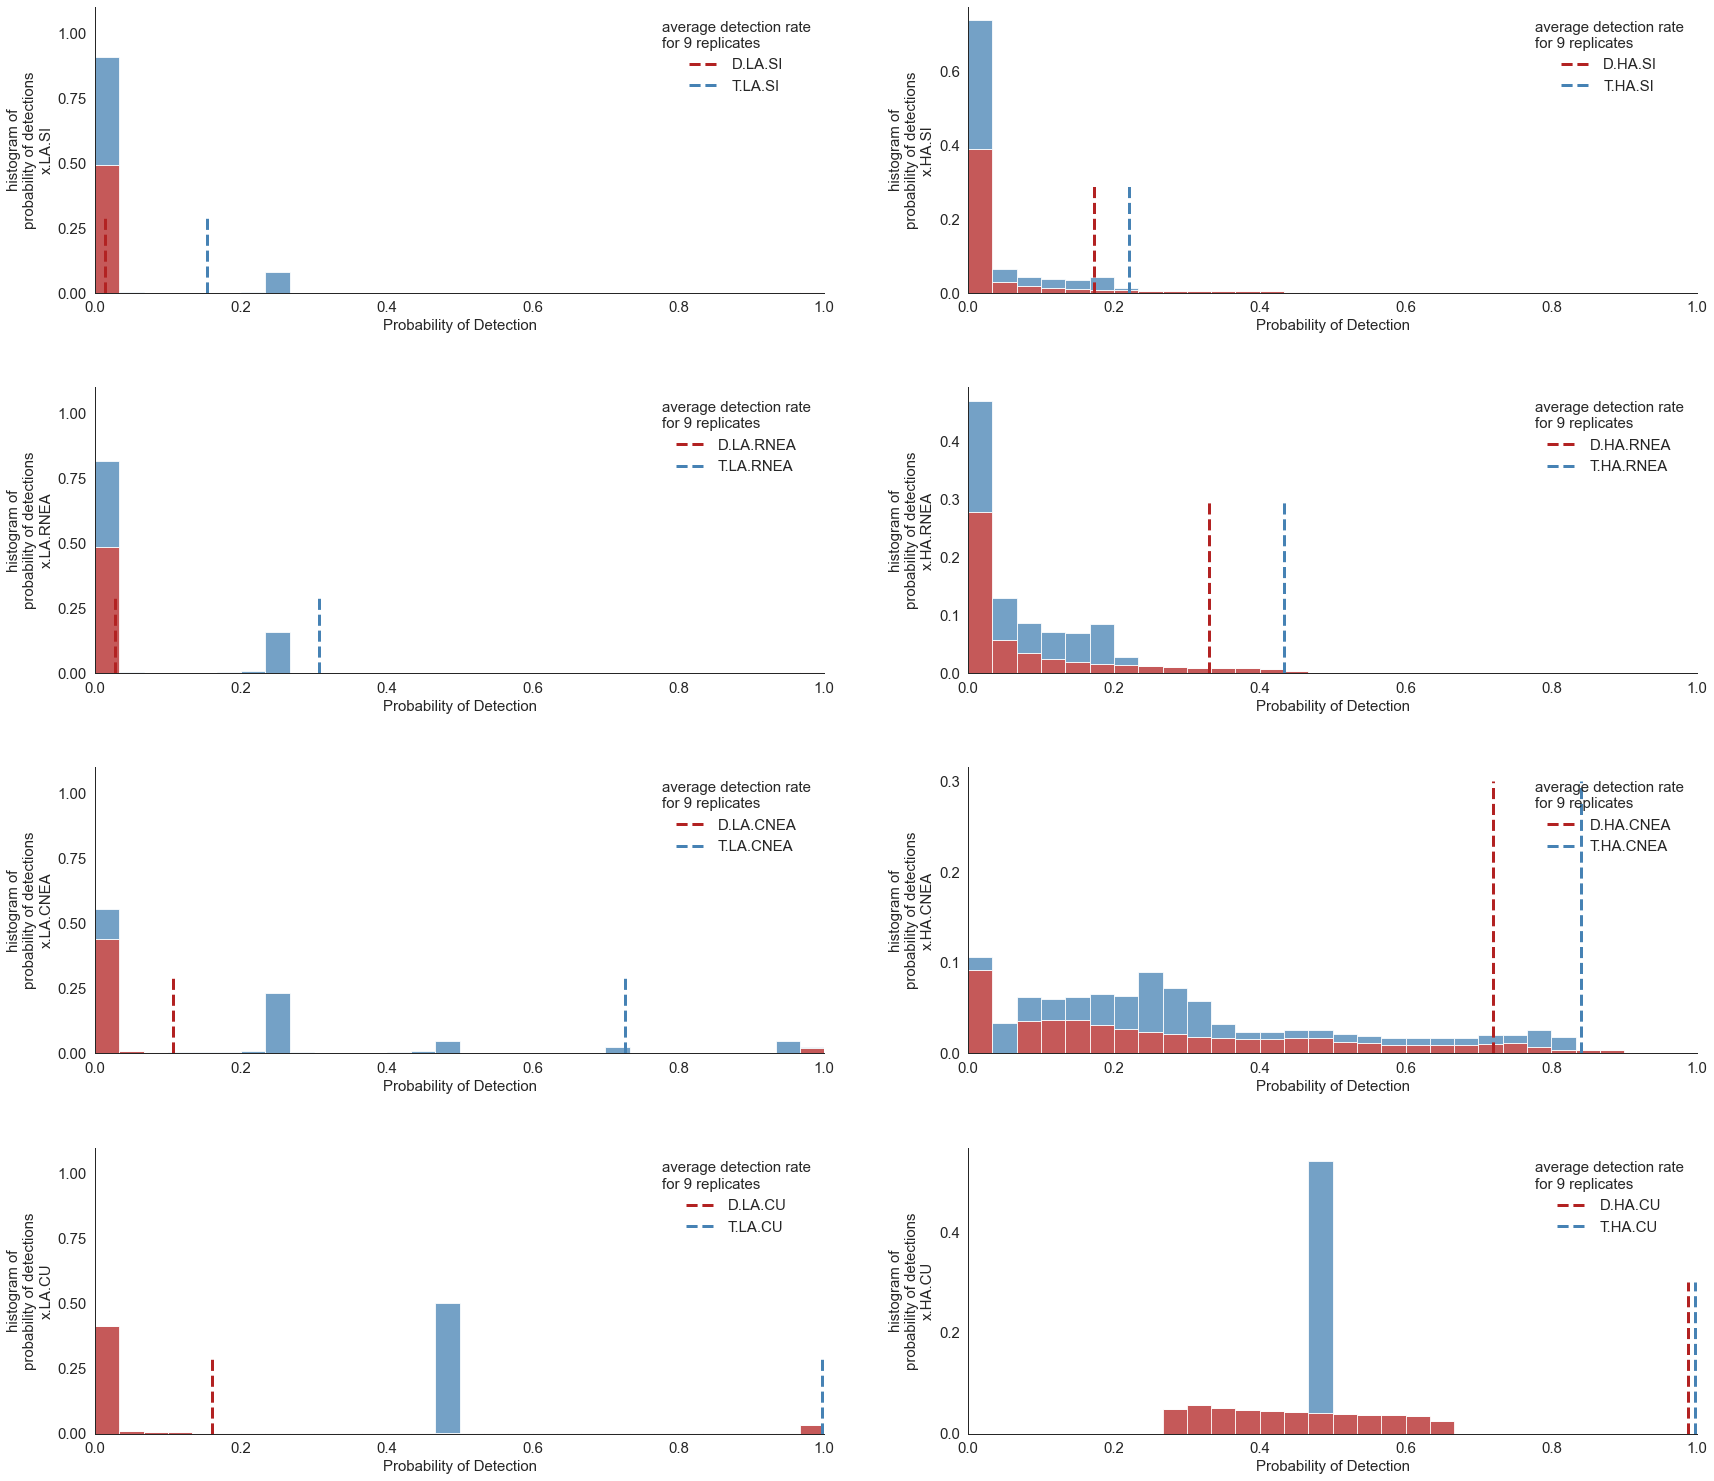

0.019676947325057547 0.1119741545705072


In [16]:
river = River()
river.init_fish(dist_bet_fish = 50, biomass = .8)
river.init_river_params(V = 0, D = 1e-3,u = 1e7/60 , λ = 2e-3, H = 50)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1e-5, time = 10*60)
river.error = 1e-1


fig, axs = plt.subplots(4, 2, figsize=(40/1.6,35/1.6), sharey=True, sharex = True)

def fish_locations(dist):
    x = 0
    returnable = []
    while x > -100 :
        a = -np.random.exponential(dist, 1)[0]
        x += a
        returnable += [x]
    returnable = returnable[::-1]
    x = 0        
    while x < 300:
        a = np.random.exponential(dist, 1)[0]
        x += a
        returnable += [x]
    return returnable


for num, fishcon in enumerate([[100], np.array([-250, 50])+200, np.array([-300, -230, -100, -50,-40, -15,-5,90]) +200, np.array(range(-800, 800, 50)) +200 ]):
    n = 9
    ranges = np.linspace(-600,600,10000)
    fishes = fishcon    #fish_locations(45) #range(-1000, 1000, 50)#
    fish_loc = [ ranges + x for x in fishes]  #ranges +
    range_list = [ np.linspace(-240 + x,240 + x,10000) for x in range(-500, 501, 50)]
    river.V = 0
    river.BV = 1e-5
    discrete1 = river.CtoP(sum([np.array([river.sample_eDNA_transect(x) for x in rg])  for rg in fish_loc]))
    river.BV = 100/600


    discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    discrete = sum(discrete_list)
    #discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]

    if num == 0:case = 'x.LA.SI'
    if num == 1:case = 'x.LA.RNEA'
    if num == 2:case = 'x.LA.CNEA'
    if num == 3:case = 'x.LA.CU'

    lg = pd.DataFrame([[x, 'transect sampling of {:.0f}m'.format(river.BV*river.T), pos] for x, pos in zip(discrete, ranges)] + [[x, 'discrete sampling', pos] for x, pos in zip(discrete1, ranges)] ,
                      columns = ['Probability of Detection', 'method', 'position'])

    #plt.legend()
    plt.subplot(4, 2, num*2 + 1)
    plt.ylim([0,max(discrete1)*1.1])
    lg = pd.DataFrame([[x, 'transect sampling of {:.0f}m'.format(river.BV*river.T), pos] for x, pos in zip(discrete, ranges)] + [[x, 'discrete sampling', pos] for x, pos in zip(discrete1, ranges)] ,
                      columns = ['Probability of Detection', 'method', 'position'])
    sns.histplot( hue = 'method', x = 'Probability of Detection',  data = lg.query(' -400 < position < 200 '),multiple="stack",
                 palette =['steelblue', 'firebrick'], stat = 'probability', bins = 30, binrange = [0,1])
    sns.despine()
    plt.vlines(x = (1- (1-lg.query(' -400 < position < 200 and method == "discrete sampling"')['Probability of Detection'])**n).mean(), 
               ymin = 0, ymax = 0.3,color = 'firebrick',linewidth = 3, linestyle = 'dashed', label = "D"+case[case.find('.'):])
    plt.vlines(x = (1-(1- lg.query(' -400 < position < 200 and method != "discrete sampling"')['Probability of Detection'])**n).mean(), 
               ymin = 0, ymax = 0.3,color = 'steelblue', linewidth = 3,linestyle = 'dashed', label = "T"+case[case.find('.'):] )
    plt.ylabel('histogram of\nprobability of detections\n'+ case, fontsize=15 )
    plt.xlim([0,1])
    plt.xlabel('Probability of Detection',fontsize = 15)
    plt.legend(loc='best', title="average detection rate\nfor {0:0d} replicates".format(n), fontsize=15, title_fontsize =15 )
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    
    river.V = 0.1
    river.BV = 1e-5
    discrete1 = river.CtoP(sum([np.array([river.sample_eDNA_transect(x) for x in rg])  for rg in fish_loc]))
    river.BV = 100/600


    discrete_list = [river.CtoP(np.array([river.sample_eDNA_transect(x) for x in rg]))  for rg in fish_loc]
    discrete = sum(discrete_list)

    if num == 0:case = 'x.HA.SI'
    if num == 1:case = 'x.HA.RNEA'
    if num == 2:case = 'x.HA.CNEA'
    if num == 3:case = 'x.HA.CU'

    lg = pd.DataFrame([[x, 'transect sampling of {:.0f}m'.format(river.BV*river.T), pos] for x, pos in zip(discrete, ranges)] + [[x, 'discrete sampling', pos] for x, pos in zip(discrete1, ranges)] ,
                      columns = ['Probability of Detection', 'method', 'position'])

    #plt.legend()
    plt.subplot(4, 2, num*2 + 2)
    plt.xlim([0,max(discrete1)*1.1])
    lg = pd.DataFrame([[x, 'transect sampling of {:.0f}m'.format(river.BV*river.T), pos] for x, pos in zip(discrete, ranges)] + [[x, 'discrete sampling', pos] for x, pos in zip(discrete1, ranges)] ,
                      columns = ['Probability of Detection', 'method', 'position'])
    sns.histplot( hue = 'method', x = 'Probability of Detection',  data = lg.query(' -400 < position < 200 '),multiple="stack",
                 palette =['steelblue', 'firebrick'], stat = 'probability', bins = 30, binrange = [0,1])
    sns.despine()
    plt.vlines(x = (1- (1-lg.query(' -400 < position < 200 and method == "discrete sampling"')['Probability of Detection'])**n).mean(), 
               ymin = 0, ymax = 0.3,color = 'firebrick',linewidth = 3, linestyle = 'dashed', label = "D"+case[case.find('.'):])
    plt.vlines(x = (1-(1- lg.query(' -400 < position < 200 and method != "discrete sampling"')['Probability of Detection'])**n).mean(), 
               ymin = 0, ymax = 0.3,color = 'steelblue', linewidth = 3,linestyle = 'dashed', label = "T"+case[case.find('.'):] )
    plt.ylabel('histogram of\nprobability of detections\n'+ case, fontsize=15 )
    plt.xlim([0,1])
    plt.xlabel('Probability of Detection',fontsize = 15)
    plt.legend(loc='best', title="average detection rate\nfor {0:0d} replicates".format(n), fontsize=15, title_fontsize =15 )
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

plt.tight_layout()
river.print_params()
plt.savefig('histogram of probability of detection.png', dpi = 100)
plt.show()
print(np.std(discrete), np.std(discrete1))


# testing figure 

In [22]:
distlist = [random.random()*100 for i in range(1000)]
river = River()
river.init_fish(dist_bet_fish = 5, biomass = 1)
river.init_river_params(V =10.0, D = 1e-3,u = 1e7/60 , λ = 2e-3, H = 50)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17


Wall time: 2.16 s


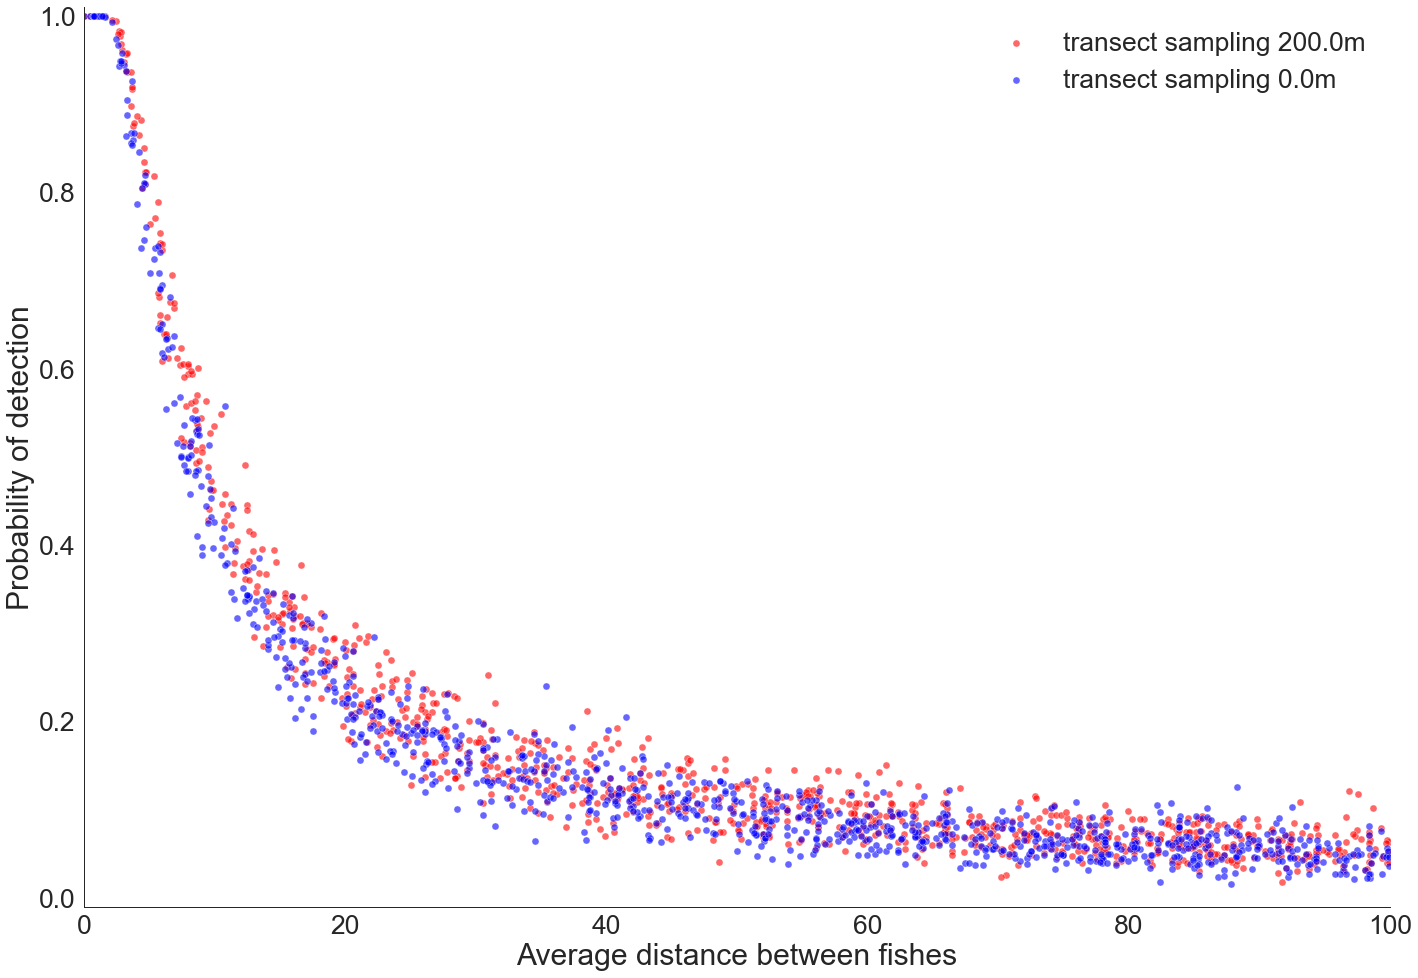

In [23]:
%%time
response = []
river.BV = 1/3
for i in distlist:
    river.dist = i
    response += [river.sample_eDNA_transect_n_sources()]
    
response = river.CtoP(response)
sns.scatterplot(x= distlist, y=response, s = 50, alpha = .6, color = 'red', label = 'transect sampling {:.1f}m'.format(river.BV*river.T))
#sns.lineplot(x= distlist, y=response, color = 'red', alpha = .3)
plt.legend(loc = 'best')

river.BV = 1e-5
response_disc = []
for i in distlist:
    river.dist = i
    response_disc += [river.sample_eDNA_transect_n_sources()]
    
response_disc = river.CtoP(response_disc)

sns.scatterplot(x= distlist, y=response_disc, s = 50, alpha = .6, color = 'blue', label = 'transect sampling {:.1f}m'.format(river.BV*river.T))
#sns.lineplot(x= distlist, y=response, color = 'blue', alpha = .3)
plt.ylabel('Probability of detection')
plt.xlabel('Average distance between fishes')
plt.ylim([-0.01,1.01])
plt.xlim([0,100])
plt.legend(loc = 'upper right')
sns.despine()

Wall time: 2.1 s


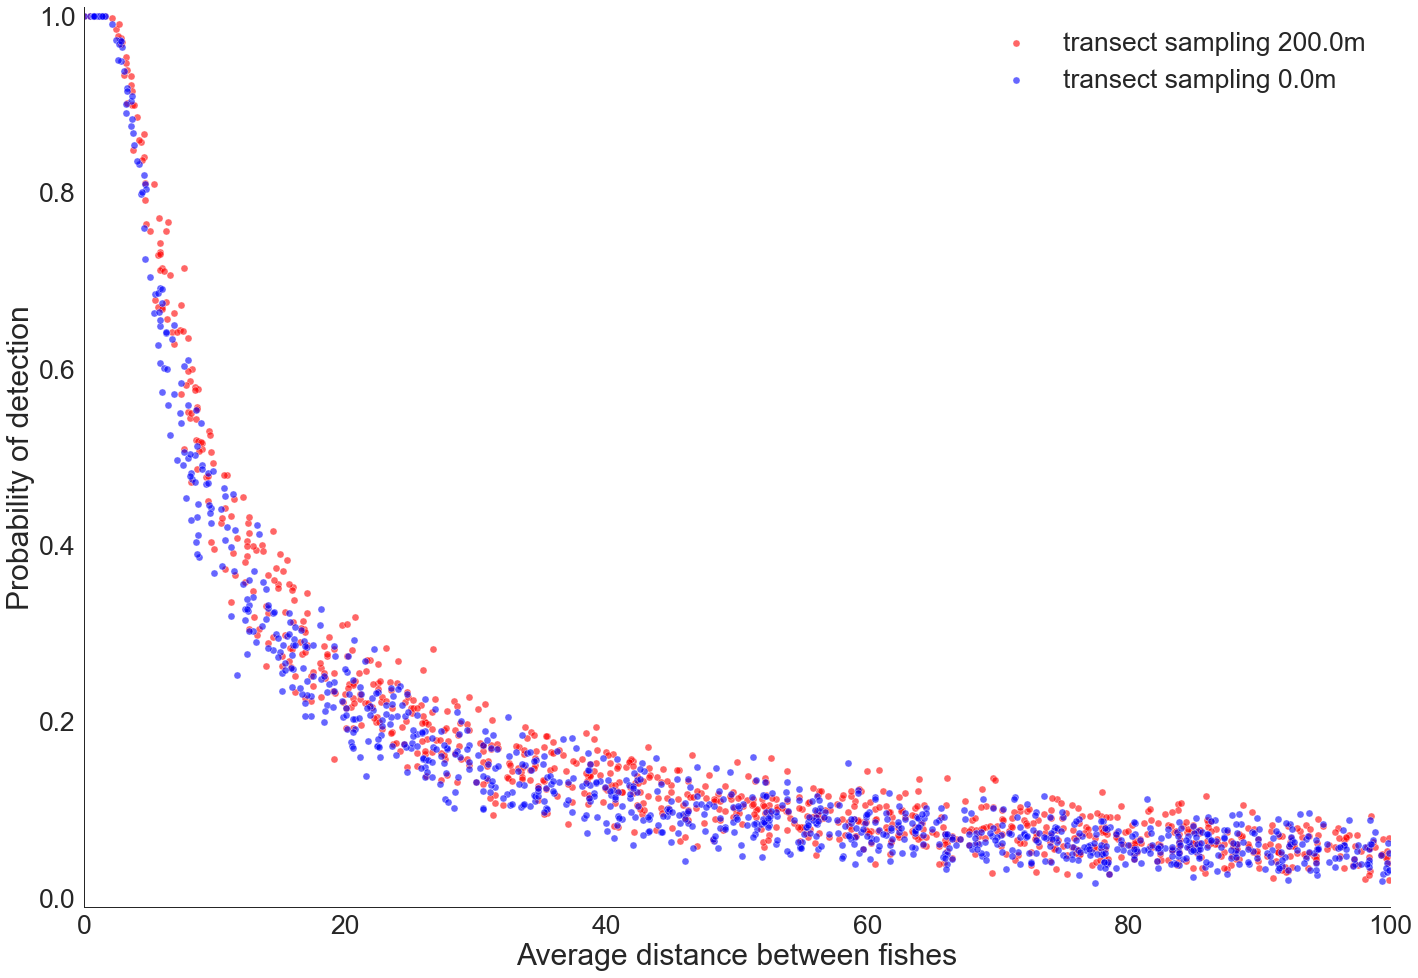

In [24]:
%%time
response = []
river.BV = 1/3
for i in distlist:
    river.dist = i
    response += [river.sample_eDNA_transect_n_sources()]
    
response = river.CtoP(response)
sns.scatterplot(x= distlist, y=response, s = 50, alpha = .6, color = 'red', label = 'transect sampling {:.1f}m'.format(river.BV*river.T))
#sns.lineplot(x= distlist, y=response, color = 'red', alpha = .3)
plt.legend(loc = 'best')

river.BV = 1e-5
response_disc = []
for i in distlist:
    river.dist = i
    response_disc += [river.sample_eDNA_transect_n_sources()]
    
response_disc = river.CtoP(response_disc)

sns.scatterplot(x= distlist, y=response_disc, s = 50, alpha = .6, color = 'blue', label = 'transect sampling {:.1f}m'.format(river.BV*river.T))
#sns.lineplot(x= distlist, y=response, color = 'blue', alpha = .3)
plt.ylabel('Probability of detection')
plt.xlabel('Average distance between fishes')
plt.ylim([-0.01,1.01])
plt.xlim([0,100])
plt.legend(loc = 'upper right')
sns.despine()

In [25]:
river = River()
river.init_fish(dist_bet_fish = 5, biomass = .01)
river.init_river_params(V =0.1, D = 1e-3,u = 1e7/60 , λ = 2e-3, H = 50)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1


%time edna_transect = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = [0,100], n = 1000)
%time net_transect = river.Catch_Transects_With_Different_Fish_Distances(dist_range = [0,100], n = 1000)

sns.scatterplot(x= edna_transect['distances'], y=edna_transect['response'], s = 70, alpha = .4, color = 'red', label = 'transect sampling eDNA {:.1f}m'.format(river.BV*river.T))
sns.scatterplot(x= net_transect['distances'], y=net_transect['detection'], s = 70, alpha = .4, color = 'red', label = 'transect sampling net {:.1f}m'.format(river.BV*river.T), marker = '^')

river.BV = 1e-5

%time edna = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = [0,100], n = 1000)
sns.scatterplot(x= edna['distances'], y=edna['response'], s = 50, alpha = .4, color = 'blue', label = 'Discrete sampling eDNA')


river.BV = 2/river.T

%time net = river.Catch_Transects_With_Different_Fish_Distances(dist_range = [0,100], n = 1000)
sns.scatterplot(x= net_transect['distances'], y=net_transect['detection'], s = 70, alpha = .4, color = 'blue', label = 'Cast Net {:.1f}m'.format(river.BV*river.T), marker = '^')


plt.legend(loc=(1.04,.6))


plt.ylabel('Probability of detection')
plt.xlabel('Average distance between fishes')
plt.ylim([-0.01,1.01])
plt.xlim([0,100])
#plt.legend(loc = 'upper right')
sns.despine()

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17


ValueError: f(a) and f(b) must have different signs

In [ ]:
def make_lis(rep = 700, init = 5, final = 100, n = 20):
    return np.array([[i for x in range(rep)] for i in np.linspace(init, final, n)]).flatten()


river = River()
river.init_fish(dist_bet_fish = 5, biomass = .01)
river.init_river_params(V =0., D = 1e-3,u = 1e7/60 , λ = 2e-3, H =50)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1
river.PofCaptureNet = 0.01


%time edna_transect = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())
df_et = pd.DataFrame(np.array([edna_transect['distances'], edna_transect['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_et['length'] =  'transect sampling {:.1f}m'.format(river.BV*river.T)
df_et['method'] = 'eDNA'

%time net_transect = river.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
df_nt = pd.DataFrame(np.array([net_transect['distances'], net_transect['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])

df_nt['length'] =  'transect sampling {:.1f}m'.format(river.BV*river.T)
df_nt['method'] = 'net'

#sns.lineplot(x= edna_transect['distances'], y=edna_transect['response'],  alpha = .4, color = 'red', label = 'transect sampling eDNA {:.1f}m'.format(river.BV*river.T), markers=True, dashes=False)
#sns.lineplot(x= net_transect['distances'], y=net_transect['detection'], alpha = .4, color = 'red', label = 'transect sampling net {:.1f}m'.format(river.BV*river.T), linestyle = '--')

river.BV = 1e-5

%time edna = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())

df_e = pd.DataFrame(np.array([edna['distances'], edna['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_e['length'] =  'discrete sampling' 
df_e['method'] = 'eDNA'

#sns.lineplot(x= edna['distances'], y=edna['response'], alpha = .4, color = 'blue', label = 'Discrete sampling eDNA')


river.BV = 2/river.T

%time net = river.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
#sns.lineplot(x= net['distances'], y=net['detection'],alpha = .4, color = 'blue', label = 'Cast Net {:.1f}m'.format(river.BV*river.T), linestyle = '--')
df_n = pd.DataFrame(np.array([net['distances'], net['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_n['length'] =  'cast net {:.1f}m'.format(river.BV*river.T)
df_n['method'] = 'net'

all_df = pd.concat([df_et,df_nt, df_e, df_n],ignore_index=True)
all_df.head(2)

In [ ]:
sns.lineplot(data = all_df, x = 'distances', y = 'Probability of detection', hue="length", style="method",
    markers=True, dashes=True, sizes = 20, linewidth = 4, ci = 'sd')
sns.despine()
plt.ylabel('Probability of detection')
plt.xlabel('Average distance between fishes')
plt.ylim([-0.01,1.01])
plt.xlim([0,100])
plt.legend(loc=(1.04,.6))
sns.despine()

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17
Wall time: 1min 31s
Wall time: 861 ms
Wall time: 1min 33s
Wall time: 472 ms


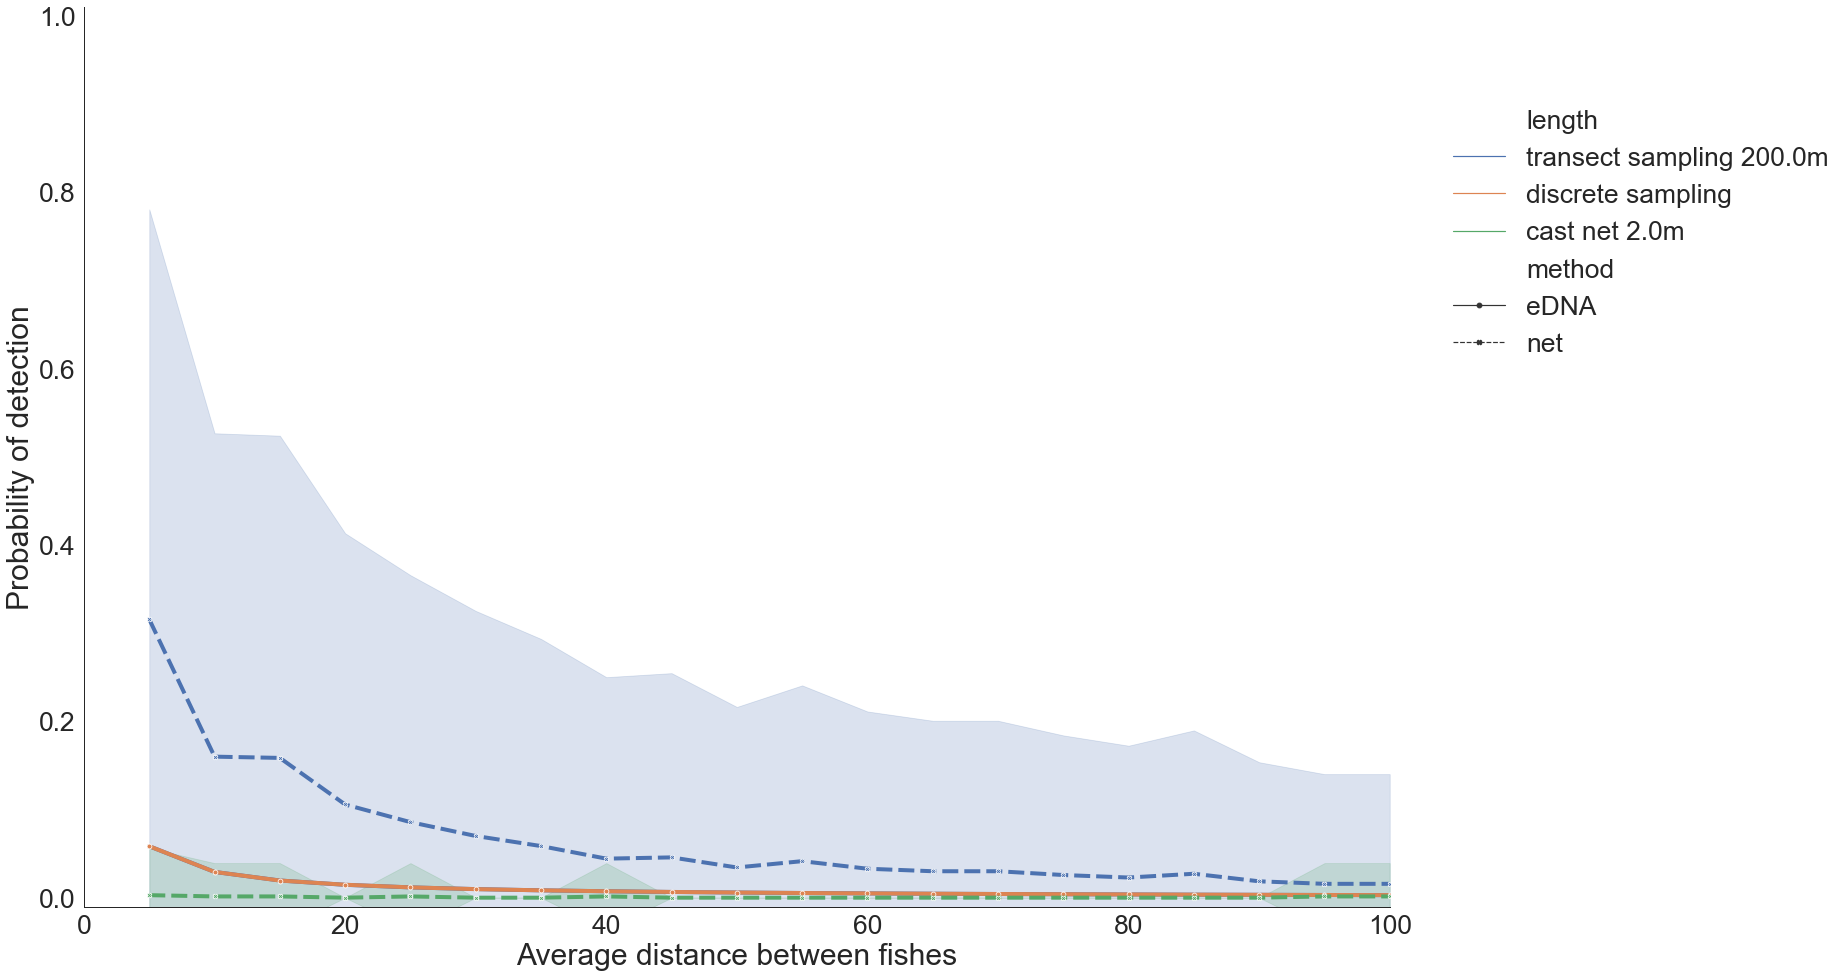

In [448]:
def make_lis(rep = 700, init = 5, final = 100, n = 20):
    return np.array([[i for x in range(rep)] for i in np.linspace(init, final, n)]).flatten()


river = River()
river.init_fish(dist_bet_fish = 5, biomass = .01)
river.init_river_params(V =10., D = 1e-3,u = 1e7/60 , λ = 2e-3, H= 50)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1
river.PofCaptureNet = 0.01


%time edna_transect = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())
df_et = pd.DataFrame(np.array([edna_transect['distances'], edna_transect['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_et['length'] =  'transect sampling {:.1f}m'.format(river.BV*river.T)
df_et['method'] = 'eDNA'

%time net_transect = river.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
df_nt = pd.DataFrame(np.array([net_transect['distances'], net_transect['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])

df_nt['length'] =  'transect sampling {:.1f}m'.format(river.BV*river.T)
df_nt['method'] = 'net'

#sns.lineplot(x= edna_transect['distances'], y=edna_transect['response'],  alpha = .4, color = 'red', label = 'transect sampling eDNA {:.1f}m'.format(river.BV*river.T), markers=True, dashes=False)
#sns.lineplot(x= net_transect['distances'], y=net_transect['detection'], alpha = .4, color = 'red', label = 'transect sampling net {:.1f}m'.format(river.BV*river.T), linestyle = '--')

river.BV = 1e-5

%time edna = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())

df_e = pd.DataFrame(np.array([edna['distances'], edna['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_e['length'] =  'discrete sampling' 
df_e['method'] = 'eDNA'

#sns.lineplot(x= edna['distances'], y=edna['response'], alpha = .4, color = 'blue', label = 'Discrete sampling eDNA')


river.BV = 2/river.T

%time net = river.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
#sns.lineplot(x= net['distances'], y=net['detection'],alpha = .4, color = 'blue', label = 'Cast Net {:.1f}m'.format(river.BV*river.T), linestyle = '--')
df_n = pd.DataFrame(np.array([net['distances'], net['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_n['length'] =  'cast net {:.1f}m'.format(river.BV*river.T)
df_n['method'] = 'net'

all_df = pd.concat([df_et,df_nt, df_e, df_n],ignore_index=True)
all_df.head(2)


sns.lineplot(data = all_df, x = 'distances', y = 'Probability of detection', hue="length", style="method",
    markers=True, dashes=True, sizes = 20, linewidth = 4, ci = 'sd')
sns.despine()
plt.ylabel('Probability of detection')
plt.xlabel('Average distance between fishes')
plt.ylim([-0.01,1.01])
plt.xlim([0,100])
plt.legend(loc=(1.04,.6))
sns.despine()

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17
Wall time: 2.53 s
Wall time: 1 s
Wall time: 492 ms
Wall time: 532 ms


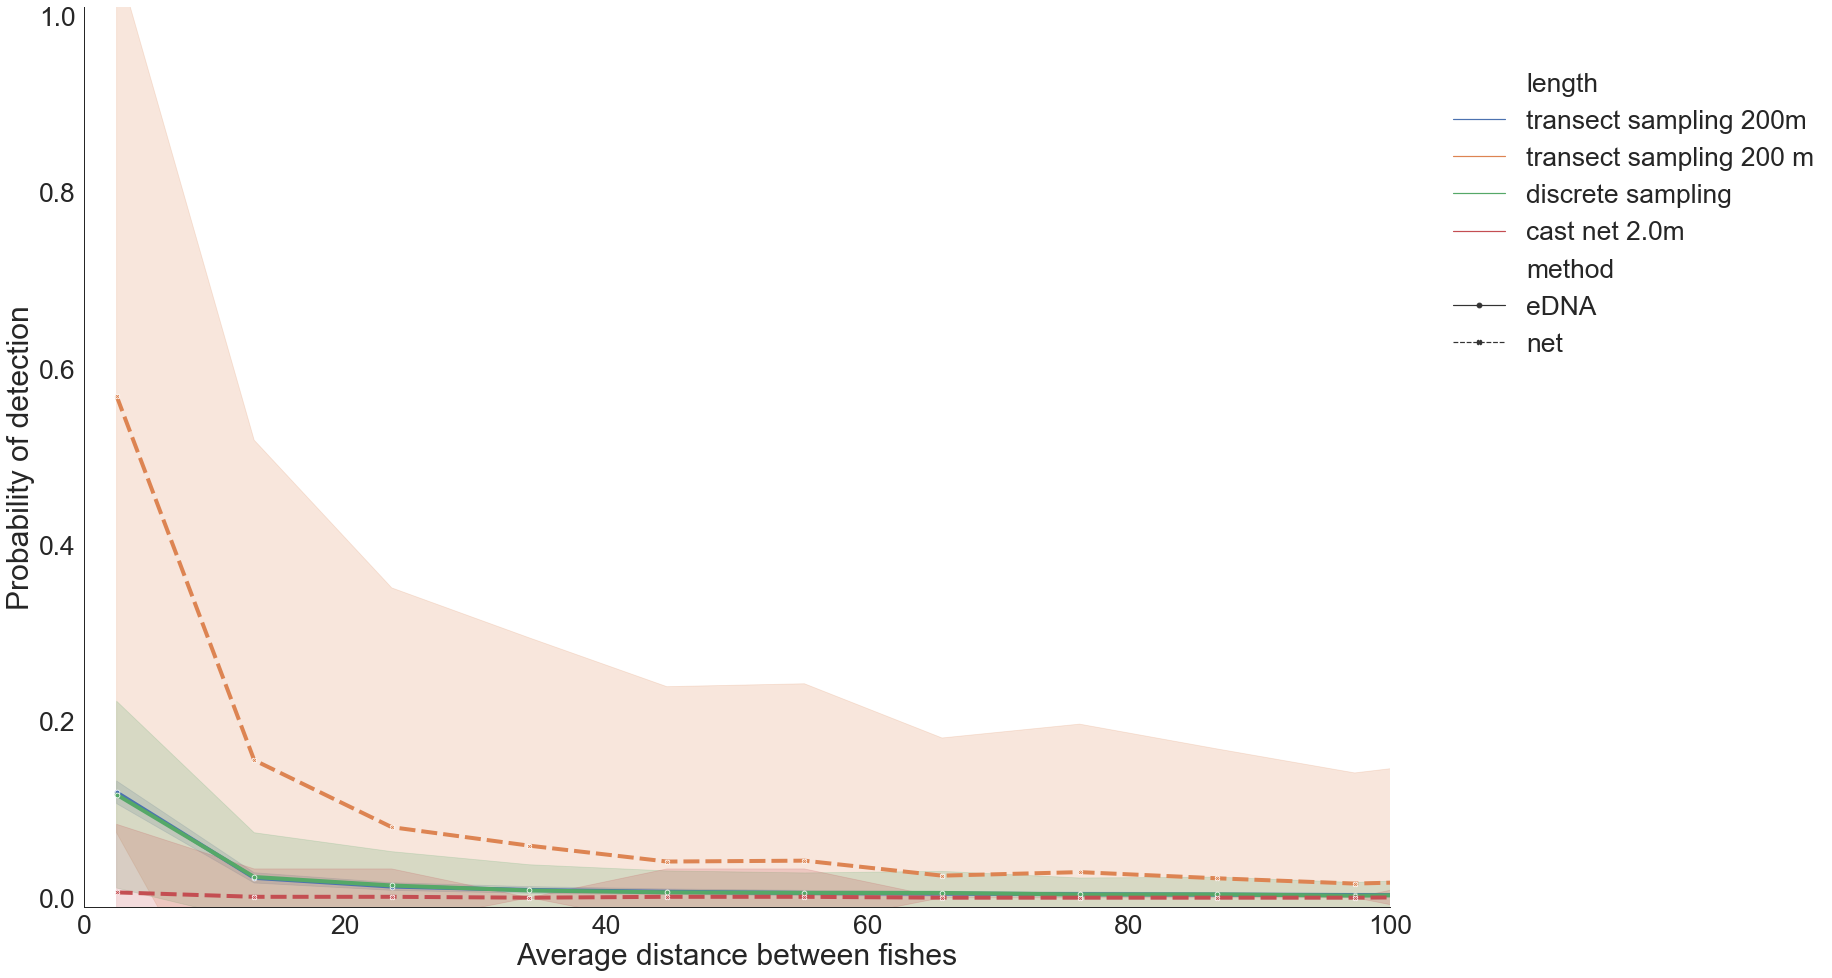

In [449]:
def make_lis(rep = 1000, init = 2.5, final = 150, n = 15):
    return np.array([[i for x in range(rep)] for i in np.linspace(init, final, n)]).flatten()


river = River()
river.init_fish(dist_bet_fish = 5, biomass = .01)
river.init_river_params(V =1e-5, D = 1e-3,u = 1e7/60 , λ = 2e-3, H = 50)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1
river.PofCaptureNet = 0.01


%time edna_transect = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())
df_et = pd.DataFrame(np.array([edna_transect['distances'], edna_transect['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_et['length'] =  'transect sampling {:.0f}m'.format(river.BV*river.T)
df_et['method'] = 'eDNA'

%time net_transect = river.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
df_nt = pd.DataFrame(np.array([net_transect['distances'], net_transect['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])

df_nt['length'] =  'transect sampling {:.0f} m'.format(river.BV*river.T)
df_nt['method'] = 'net'

#sns.lineplot(x= edna_transect['distances'], y=edna_transect['response'],  alpha = .4, color = 'red', label = 'transect sampling eDNA {:.1f}m'.format(river.BV*river.T), markers=True, dashes=False)
#sns.lineplot(x= net_transect['distances'], y=net_transect['detection'], alpha = .4, color = 'red', label = 'transect sampling net {:.1f}m'.format(river.BV*river.T), linestyle = '--')

river.BV = 1e-5

%time edna = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())

df_e = pd.DataFrame(np.array([edna['distances'], edna['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_e['length'] =  'discrete sampling' 
df_e['method'] = 'eDNA'

#sns.lineplot(x= edna['distances'], y=edna['response'], alpha = .4, color = 'blue', label = 'Discrete sampling eDNA')


river.BV = 2/river.T

%time net = river.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
#sns.lineplot(x= net['distances'], y=net['detection'],alpha = .4, color = 'blue', label = 'Cast Net {:.1f}m'.format(river.BV*river.T), linestyle = '--')
df_n = pd.DataFrame(np.array([net['distances'], net['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_n['length'] =  'cast net {:.1f}m'.format(river.BV*river.T)
df_n['method'] = 'net'

all_df = pd.concat([df_et,df_nt, df_e, df_n],ignore_index=True)
all_df.head(2)


sns.lineplot(data = all_df, x = 'distances', y = 'Probability of detection', hue="length", style="method",
    markers=True, dashes=True, sizes = 20, linewidth = 4, ci = 'sd')
sns.despine()
plt.ylabel('Probability of detection')
plt.xlabel('Average distance between fishes')
plt.ylim([-0.01,1.01])
plt.xlim([0,100])
sns.despine()
#sns.scatterplot(x = 'distances', y = 'Probability of detection', hue="length", linewidth=0,     data=all_df, alpha = .01)
plt.legend(loc=(1.04,.6))


In [ ]:
%%time
from ipywidgets import interact, interact_manual, interactive,interactive_output, Layout
import ipywidgets as widgets
def make_lis(rep = 1000, init = 2.5, final = 200, n = 50):
    return np.array([[i for x in range(rep)] for i in np.linspace(init, final, n)]).flatten()



@interact_manual(
                 biomass_of_fish_cluster = widgets.FloatSlider(value=.05, min=0.01, max=.1, step=0.01, continuous_update=False, orientation='horizontal', readout=True, readout_format='.3f'),
                 river_velocity = widgets.FloatSlider(value=0.001, min=0.00001, max=1, step=0.1, continuous_update=False, orientation='horizontal', readout=True, readout_format='.1f'),
                 diffusion = widgets.FloatSlider(value=1e-3, min=1e-4, max=1e-2, step=1e-4,  continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 degradation = widgets.FloatSlider(value=2e-3, min=1e-4, max=1e-2, step=1e-4, continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 eDNA_production_rate = widgets.FloatSlider(value=1e7/60, min=1e6/60, max=1e8/60, step=1e6/60, continuous_update=False, orientation='horizontal', readout=True, readout_format='.0f'),
                 boat_velocity = widgets.FloatSlider(value=1/3, min=1e-5, max=3, step=0.1,continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 transect_duration = widgets.FloatSlider(value=600, min=6, max=6000, step=1,  continuous_update=False, orientation='horizontal', readout=True, readout_format='.0f'),
                 pump_flow = widgets.FloatSlider(value=5*1e-3, min=5*1e-4, max=5*1e-2, step=5*1e-4, continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 probability_of_capture = widgets.FloatSlider(value=0.05, min=0.00001, max=1, step=0.01, continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 cross_section = widgets.FloatSlider(value=50, min=.1, max=100, step=0.01, continuous_update=False, orientation='horizontal', readout=True, readout_format='.1f'),
                )
def plot(biomass_of_fish_cluster, river_velocity, diffusion,degradation, eDNA_production_rate ,boat_velocity, transect_duration,pump_flow, probability_of_capture, cross_section ):

    river2 = River()
    river2.init_fish(dist_bet_fish = 10, biomass = biomass_of_fish_cluster)
    river2.init_river_params(V =river_velocity, D = diffusion,u = eDNA_production_rate , λ = degradation, H = cross_section)
    river2.init_sampling_strategy(pf= pump_flow, boat_V= boat_velocity, time = transect_duration)
    river2.error = 1e-1
    river2.PofCaptureNet = 0.05


    edna_transect2 = river2.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())
    df_et2 = pd.DataFrame(np.array([edna_transect2['distances'], edna_transect2['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
    df_et2['length'] =  'eDNA transect sampling {:.0f}m'.format(river2.BV*river2.T)
    df_et2['method'] = 'eDNA'

    net_transect2 = river2.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
    df_nt2 = pd.DataFrame(np.array([net_transect2['distances'], net_transect2['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])

    df_nt2['length'] =  'net transect sampling {:.0f}m'.format(river2.BV*river2.T)
    df_nt2['method'] = 'net'

    #sns.lineplot(x= edna_transect['distances'], y=edna_transect['response'],  alpha = .4, color = 'red', label = 'transect sampling eDNA {:.1f}m'.format(river.BV*river.T), markers=True, dashes=False)
    #sns.lineplot(x= net_transect['distances'], y=net_transect['detection'], alpha = .4, color = 'red', label = 'transect sampling net {:.1f}m'.format(river.BV*river.T), linestyle = '--')

    river2.BV = 1e-5

    edna2 = river2.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())

    df_e2 = pd.DataFrame(np.array([edna2['distances'], edna2['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
    df_e2['length'] =  'discrete sampling' 
    df_e2['method'] = 'eDNA'

    #sns.lineplot(x= edna['distances'], y=edna['response'], alpha = .4, color = 'blue', label = 'Discrete sampling eDNA')


    river2.BV = 2/river2.T

    net2 = river2.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
    #sns.lineplot(x= net['distances'], y=net['detection'],alpha = .4, color = 'blue', label = 'Cast Net {:.1f}m'.format(river.BV*river.T), linestyle = '--')
    df_n2 = pd.DataFrame(np.array([net2['distances'], net2['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
    df_n2['length'] =  'cast net {:.1f}m'.format(river2.BV*river2.T)
    df_n2['method'] = 'net'

    all_df2 = pd.concat([df_et2,df_nt2, df_e2, df_n2],ignore_index=True)
    all_df2.head(2)


    sns.lineplot(data = all_df2, x = 'distances', y = 'Probability of detection', hue="length", style="method", ci = 'sd',
        markers=True, dashes=True, sizes = 20, linewidth = 4) #, ci = 'sd'
    sns.despine()
    plt.ylabel('Probability of detection')
    plt.xlabel('Average distance between fishes')
    plt.ylim([-0.01,1.01])
    plt.xlim([0,200])
    sns.despine()
    #sns.scatterplot(x = 'distances', y = 'Probability of detection', hue="length", linewidth=0, data=all_df2, alpha = .01)
    plt.legend(loc=(1.04,.6))


In [ ]:
str(11)

In [30]:
from ipywidgets import interact, interact_manual, interactive,interactive_output, Layout
import ipywidgets as widgets
def make_lis(rep = 100, init = 2.5, final = 150, n = 100):
    return np.array([[i for x in range(rep)] for i in np.linspace(init, final, n)]).flatten()



@interact_manual(
                 biomass_of_fish_cluster = widgets.FloatSlider(value=.5, min=0.01, max=1, step=0.01, continuous_update=False, orientation='horizontal', readout=True, readout_format='.3f'),
                 river_velocity = widgets.FloatSlider(value=0.001, min=0.00001, max=1, step=0.1, continuous_update=False, orientation='horizontal', readout=True, readout_format='.1f'),
                 diffusion = widgets.FloatSlider(value=1e-3, min=1e-4, max=1e-2, step=1e-4,  continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 degradation = widgets.FloatSlider(value=2e-3, min=1e-4, max=1e-2, step=1e-4, continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 eDNA_production_rate = widgets.FloatSlider(value=1e7/60, min=1e6/60, max=1e8/60, step=1e6/60, continuous_update=False, orientation='horizontal', readout=True, readout_format='.0f'),
                 #boat_velocity = widgets.FloatSlider(value=1/3, min=1e-5, max=3, step=0.1,continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 transect_duration = widgets.FloatSlider(value=600, min=6, max=6000, step=1,  continuous_update=False, orientation='horizontal', readout=True, readout_format='.0f'),
                 pump_flow = widgets.FloatSlider(value=5*1e-3, min=5*1e-4, max=5*1e-2, step=5*1e-4, continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 #probability_of_capture = widgets.FloatSlider(value=0.05, min=0.00001, max=1, step=0.01, continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 max_fish_dist = widgets.FloatSlider(value=300, min=100, max=10000, step=10, continuous_update=False, orientation='horizontal', readout=True, readout_format='.0f'),
                 n_reps =  widgets.IntSlider(value=800, min=20, max=1000, step=10, continuous_update=False, orientation='horizontal', readout=True, readout_format='.0f'),
                 cross_section = widgets.FloatSlider(value=50, min=.1, max=100, step=0.01, continuous_update=False, orientation='horizontal', readout=True, readout_format='.1f'),
                )
def plot(biomass_of_fish_cluster, river_velocity, diffusion,degradation, eDNA_production_rate , transect_duration,pump_flow, max_fish_dist, n_reps,cross_section  ):
    river2 = River()
    river2.init_fish(dist_bet_fish = 10, biomass = biomass_of_fish_cluster)
    river2.init_river_params(V =river_velocity, D = diffusion,u = eDNA_production_rate , λ = degradation, H = cross_section)
    river2.init_sampling_strategy(pf= pump_flow, boat_V= 1, time = transect_duration)
    river2.error = 1e-1
    river2.PofCaptureNet = 0.05
    
    df_lis = []
    fig, axs = plt.subplots(2, 1,  sharey=True, sharex = True, figsize = (20,20))
    plt.subplot(211)
    for boatV in np.array([1e-5, 10, 50,200,  500, 1000])/river2.T: #np.logspace(-5, 1, num = 15):    [1e-5, 10, 50,  200,500, 1000]
        river2.init_sampling_strategy(pf= pump_flow, boat_V= boatV, time = transect_duration)
        edna_transect2 = river2.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis(rep = n_reps,final = max_fish_dist ,n = 50))
        df_et2 = pd.DataFrame(np.array([edna_transect2['distances'], edna_transect2['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
        df_et2['length'] =  '{:.0f}m'.format(river2.BV*river2.T)
        df_lis += [df_et2]
        
    dfp = pd.concat(df_lis)
    sns.despine()
    sns.lineplot(data = dfp, x = 'distances', y = 'Probability of detection', hue="length", linewidth = 2, alpha = 1,palette = 'RdBu', ci = 'sd' ) 
    plt.ylabel('Probability of detection')
    plt.xlabel('Average distance between eDNA sources')
    plt.ylim([-0.0,1.01])
    plt.xlim([0,max_fish_dist])
    plt.legend(loc='best', title = 'eDNA transect\nsampling distance\nx.LA.CNEA')
    
    
    plt.subplot(212)
    river2.V = .1
    df_lis = []
    for boatV in np.array([1e-5, 10, 50,200,  500, 1000])/river2.T: #np.logspace(-5, 1, num = 15):    [1e-5, 10, 50,  200,500, 1000]
        river2.init_sampling_strategy(pf= pump_flow, boat_V= boatV, time = transect_duration)
        edna_transect2 = river2.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis(rep = n_reps,final = max_fish_dist ,n = 50))
        df_et2 = pd.DataFrame(np.array([edna_transect2['distances'], edna_transect2['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
        df_et2['length'] =  '{:.0f}m'.format(river2.BV*river2.T)
        df_lis += [df_et2]
        
    dfp = pd.concat(df_lis)
    sns.despine()
    sns.lineplot(data = dfp, x = 'distances', y = 'Probability of detection', hue="length", linewidth = 2, alpha = 1,palette = 'BrBG', ci = 'sd' ) #  ci = 'sd'    
    #sns.scatterplot(data = dfp, x = 'distances', y = 'Probability of detection', hue="length", linewidth = .5, alpha = .3, palette = 'coolwarm' )
    plt.ylabel('Probability of detection')
    plt.xlabel('Average distance between eDNA sources')
    plt.ylim([-0.0,1.01])
    plt.xlim([0,max_fish_dist])
    sns.despine()
    #plt.title ('Fish weight: {:.0f}g/Fish; Advection {:.2f}m/s; Sampled Volume {:.0f}L'.format(river2.B*1000, river2.V, river2.pf*river2.T))
    plt.legend(loc='best', title = 'eDNA transect\nsampling distance\nx.HA.CNEA')
    plt.savefig('probability of detection vs AFD.png', dpi = 100)
    river2.print_params()
    

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='biomass_of_fish_cluster', m…

B=0.01 dist=5 V=0.1 u=166666.66666666666 λ=0.002 D=0.001 H=50 pf=0.005


In [450]:
from ipywidgets import interact, interact_manual, interactive,interactive_output, Layout
import ipywidgets as widgets
def make_lis(rep = 100, init = 2.5, final = 150, n = 100):
    return np.array([[i for x in range(rep)] for i in np.linspace(init, final, n)]).flatten()



@interact_manual(
                 biomass_of_fish_cluster = widgets.FloatSlider(value=.5, min=0.01, max=1, step=0.01, continuous_update=False, orientation='horizontal', readout=True, readout_format='.3f'),
                 river_velocity = widgets.FloatSlider(value=0.001, min=0.00001, max=1, step=0.1, continuous_update=False, orientation='horizontal', readout=True, readout_format='.1f'),
                 diffusion = widgets.FloatSlider(value=1e-3, min=1e-4, max=1e-2, step=1e-4,  continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 degradation = widgets.FloatSlider(value=2e-3, min=1e-4, max=1e-2, step=1e-4, continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 eDNA_production_rate = widgets.FloatSlider(value=1e7/60, min=1e6/60, max=1e8/60, step=1e6/60, continuous_update=False, orientation='horizontal', readout=True, readout_format='.0f'),
                 #boat_velocity = widgets.FloatSlider(value=1/3, min=1e-5, max=3, step=0.1,continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 transect_duration = widgets.FloatSlider(value=600, min=6, max=6000, step=1,  continuous_update=False, orientation='horizontal', readout=True, readout_format='.0f'),
                 pump_flow = widgets.FloatSlider(value=5*1e-3, min=5*1e-4, max=5*1e-2, step=5*1e-4, continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 #probability_of_capture = widgets.FloatSlider(value=0.05, min=0.00001, max=1, step=0.01, continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 max_fish_dist = widgets.FloatSlider(value=300, min=100, max=10000, step=10, continuous_update=False, orientation='horizontal', readout=True, readout_format='.0f'),
                 n_reps =  widgets.IntSlider(value=800, min=20, max=1000, step=10, continuous_update=False, orientation='horizontal', readout=True, readout_format='.0f'),
                 cross_section = widgets.FloatSlider(value=50, min=.1, max=100, step=0.01, continuous_update=False, orientation='horizontal', readout=True, readout_format='.1f'),
                )
def plot(biomass_of_fish_cluster, river_velocity, diffusion,degradation, eDNA_production_rate , transect_duration,pump_flow, max_fish_dist, n_reps,cross_section  ):
    river2 = River()
    river2.init_fish(dist_bet_fish = 10, biomass = biomass_of_fish_cluster)
    river2.init_river_params(V =river_velocity, D = diffusion,u = eDNA_production_rate , λ = degradation, H = cross_section)
    river2.init_sampling_strategy(pf= pump_flow, boat_V= 1, time = transect_duration)
    river2.error = 1e-1
    river2.PofCaptureNet = 0.05
    
    df_lis = []
    
    for boatV in np.array([1e-5, 10, 50,200,  500, 1000])/river2.T: #np.logspace(-5, 1, num = 15):    [1e-5, 10, 50,  200,500, 1000]
        river2.init_sampling_strategy(pf= pump_flow, boat_V= boatV, time = transect_duration)
        edna_transect2 = river2.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis(rep = n_reps,final = max_fish_dist ,n = 50))
        df_et2 = pd.DataFrame(np.array([edna_transect2['distances'], edna_transect2['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
        df_et2['length'] =  '{:.0f}m'.format(river2.BV*river2.T)
        df_lis += [df_et2]
        
    dfp = pd.concat(df_lis)
    sns.despine()
    sns.lineplot(data = dfp, x = 'distances', y = 'Probability of detection', hue="length", linewidth = 7, alpha = 1,palette = 'coolwarm', ci = 'sd' ) #  ci = 'sd'
    #sns.scatterplot(data = dfp, x = 'distances', y = 'Probability of detection', hue="length", linewidth = .5, alpha = .3, palette = 'coolwarm' )
    plt.ylabel('Probability of detection')
    plt.xlabel('Average distance between fishes')
    plt.ylim([-0.0,1.01])
    plt.xlim([0,max_fish_dist])
    sns.despine()
    #plt.title ('Fish weight: {:.0f}g/Fish; Advection {:.2f}m/s; Sampled Volume {:.0f}L'.format(river2.B*1000, river2.V, river2.pf*river2.T))
    plt.legend(loc=(1.01,.25), title = 'eDNA transect\nsampling distance')
    


interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='biomass_of_fish_cluster', m…

## where are the fishes at??


In [410]:
 1- 0.05**(1/9)

0.2831288355631135

In [ ]:
166666 == int(1e7/60)

In [392]:
river = River()
river.init_fish(dist_bet_fish = 5, biomass = 1)
river.init_river_params(V =1e-5, D = 1e-3,u = 1e7/60 , λ = 2e-3, H = 50)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1
river.PofCaptureNet = 0.01

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17


In [393]:
from itertools import product
from scipy.ndimage.filters import gaussian_filter, median_filter

In [434]:
river = River()
river.init_fish(dist_bet_fish = 5, biomass = 1)
river.init_river_params(V =1e-10, D = 1e-3,u = 1e7/60 , λ = 2e-3, H = 50)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1
river.PofCaptureNet = 0.01

sma = []
certaity =  1- 0.05**(1/9)
bv_space = np.linspace(1e-10, 110/600, 100) # np.array([1e-5, 0.05, .5])
rivV_space =  np.linspace(0, .21,  100) #np.array([1e-5, .1, .3])
for bv,V in product(bv_space, rivV_space):
    try:
        river.init_river_params(V =V, D = 1e-3,u = 1e7/60 , λ = 2e-3, H = 50)
        river.init_sampling_strategy(pf= 5*1e-3, boat_V= bv, time = 10*60)
        down, up = river.Find_detection_range(certaity)
        sma += [[V, bv*river.T, up, down]]
    except: sma += [[V, bv*river.T,0,0]]
    #sma += [[V, bv, river.sup + river.BV*river.T, river.inf]]
lg =pd.DataFrame(sma, columns = ['Advection', 'Transect length', 'sup', 'inf'])
lg['group'] = lg.apply(lambda row: 'Adv: {:.2f}; Boat_V: {:.2f}'.format(row['Advection'], row['Transect length']), axis = 1)
lg['space'] = lg.apply(lambda row: list(range(int(row['inf']), int(row['sup']))), axis = 1)
lg['length'] = lg.sup -lg.inf
lg = lg.sort_values(['Advection', 'Transect length'], ascending = False)

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17


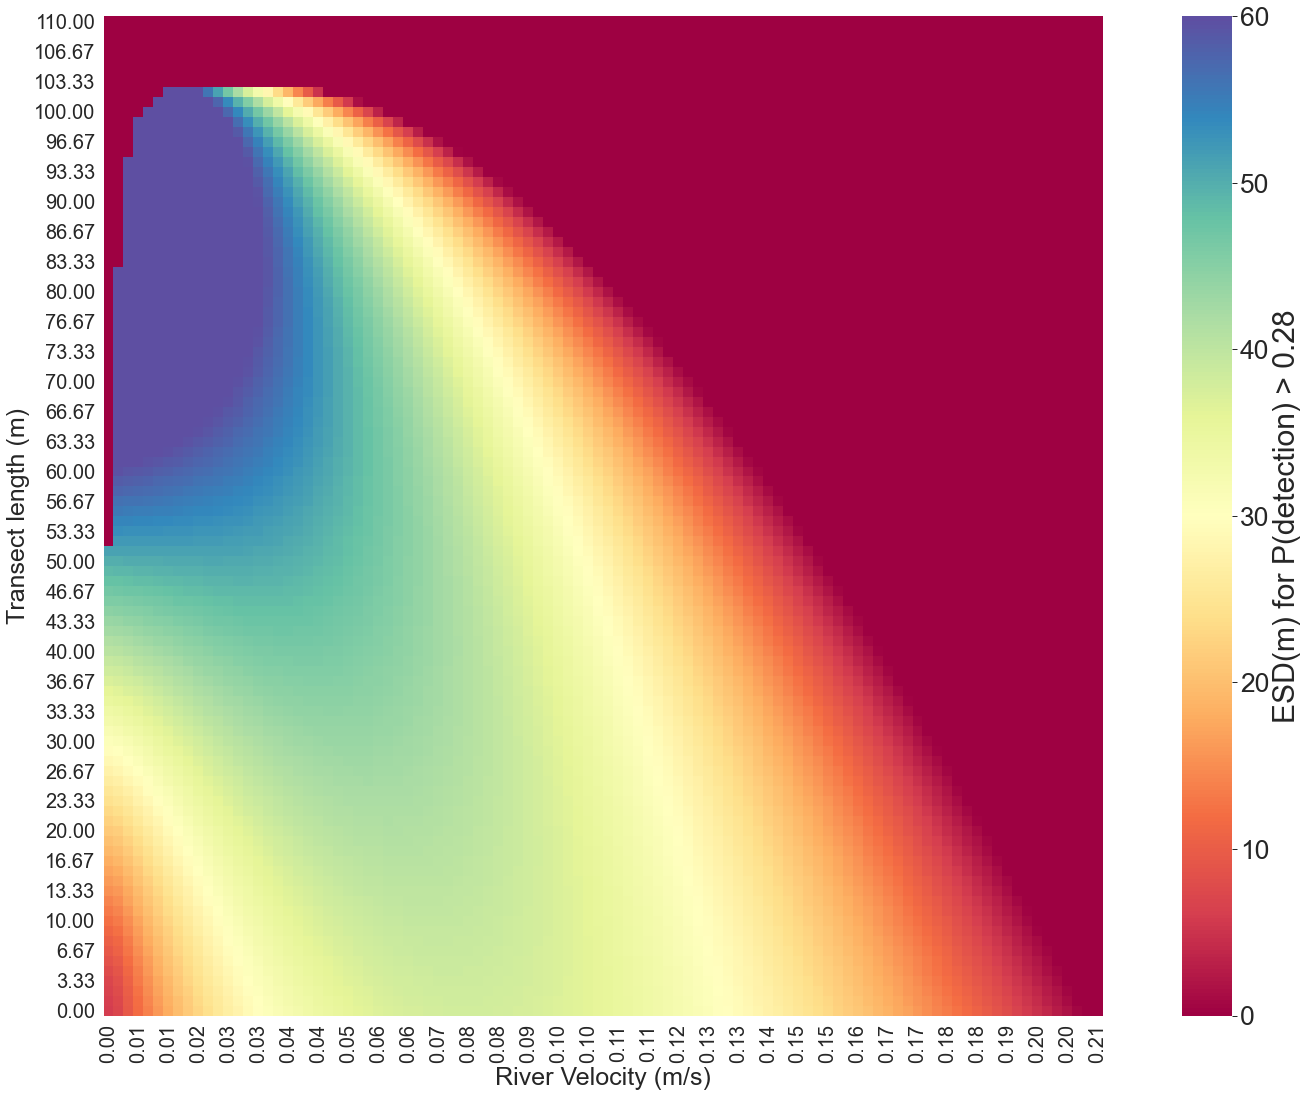

In [444]:
#sns.set(font_scale=2)
a = sns.heatmap(gaussian_filter(lg[['Transect length', 'Advection', 'length']].pivot('Transect length', 'Advection'), 0), cmap = 'Spectral',  
            xticklabels = [ "{:.2f}".format(y) if x  % 3 ==0 else '' for x, y in enumerate(rivV_space)],
            yticklabels = [ "{:.2f}".format(y) if x  % 3 ==0 else '' for x, y in enumerate(bv_space*river.T)],
            cbar_kws={'label': 'ESD(m) for P(detection) > '+ f"{certaity:.2f}"}, #  effective sampled length (m) 
            vmax = 60,
            square = 1 )


plt.xticks(fontsize = 20)
a.invert_yaxis()
plt.yticks(fontsize = 20)
#plt.xlim([0,rivV_space[-1]])
#plt.ylim([0,bv_space[-1]])

plt.ylabel("Transect length (m)",fontsize = 25)
plt.xlabel("River Velocity (m/s)",fontsize = 25)
plt.tight_layout()
plt.savefig('heatmap.png', dpi = 100)

In [430]:
#plt.hlines(y='group', xmin='inf', xmax='sup', color='blue', alpha=0.4, data = lg,linewidth =10)
#plt.scatter(x = 'inf', y = 'group', color='skyblue', alpha=1, data = lg, s= 1000)
#plt.scatter(x = 'sup', y = 'group', color='skyblue', alpha=1, data = lg,s= 1000)
#sns.despine()
#plt.grid()

In [195]:
#sns.displot( data = lg.explode('space'), x= 'space', hue = 'group',multiple="fill", height = 10, palette="coolwarm", bins = 100)

In [197]:
def Find_detection_range(p):
    max_up = optimize.bisect(lambda d: river.CtoP(river._sld_intermediary(-d, -d+river.BV*river.T))[0] - p, 0, 1e10)
    max_down = optimize.bisect(lambda d: river.CtoP(river._sld_intermediary(-d, -d+river.BV*river.T))[0] - p, -1e10, 0)
    return sorted([max_down, max_up])

In [28]:
optimize.bisect(lambda d: river.CtoP(river._sld_intermediary(-d, -d+river.BV*river.T))[0] - 0.05, -1e10, 0)

ValueError: f(a) and f(b) must have different signs

In [34]:
Find_detection_range(0.001)

[-888.0797890152134, 294.944452964833]

In [92]:
river.V

0.50005

In [55]:
river.CtoP(river._sld_intermediary(10, 11))

array([0.0680736])

In [61]:
river.CtoP(river._sld_intermediary(0, river.BV*river.T))

array([1.])

In [38]:
river.sample_eDNA_transect(0)

500.06703778677206

In [39]:
river.sample_eDNA_transect(1)

499.7776630345827

# Compare effects of advection and trasect size  on detection radius

In [375]:
river = River()
river.init_fish(dist_bet_fish = 5, biomass = 1)
river.init_river_params(V =1e-5, D = 1e-3,u = 1e7/60 , λ = 2e-3, H = 50)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1
river.PofCaptureNet = 0.01

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17


In [382]:
sma = []
xran = 4
min_percentage = .2
bv_space = np.linspace(1e-4, xran, 100) 
rivV_space =  np.linspace(1e-4, xran,  100)
for bv in bv_space:
    try:
        river.init_river_params(V =1e-5, D = 1e-3,u = 1e7/60 , λ = 2e-3, H = 50)
        river.init_sampling_strategy(pf= 5*1e-3, boat_V= bv, time = 10*60)
        down, up = river.Find_detection_range(min_percentage)
        sma += [[0, bv, up, down, 'vessel velocity only']]
    except:
        sma += [[0, bv, 0, 0, 'vessel velocity only']]
    
for mv in rivV_space:
    try:
        river.init_river_params(V =mv , D = 1e-3,u = 1e7/60 , λ = 2e-3, H = 50)
        river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1e-5, time = 10*60)
        down, up = river.Find_detection_range(min_percentage)
        sma += [[mv, 1e-5, up, down, 'river velocity only']]
    except:
        sma += [[mv, 1e-5, 0, 0, 'river velocity only']]
    

for both in np.linspace(1e-4, xran,  100):
    try:
        river.init_river_params(V =both , D = 1e-3,u = 1e7/60 , λ = 2e-3, H = 50)
        river.init_sampling_strategy(pf= 5*1e-3, boat_V= both, time = 10*60)
        down, up = river.Find_detection_range(min_percentage)
        sma += [[both, both, up, down, 'vessel and river velocity']]
    except:
        sma += [[both, both, 0, 0, 'vessel and river velocity']]

lg =pd.DataFrame(sma, columns = ['Advection', 'Boat speed', 'sup', 'inf', 'factor'])
lg['group'] = lg.apply(lambda row: 'Adv: {:.2f}; Boat_V: {:.2f}'.format(row['Advection'], row['Boat speed']), axis = 1)
lg['space'] = lg.apply(lambda row: list(range(int(row['inf']), int(row['sup']))), axis = 1)
lg['length'] = lg.sup -lg.inf
lg['velocity'] = lg.apply(lambda row: max([row['Advection'], row['Boat speed']]), axis = 1)

(-0.0, 0.2)

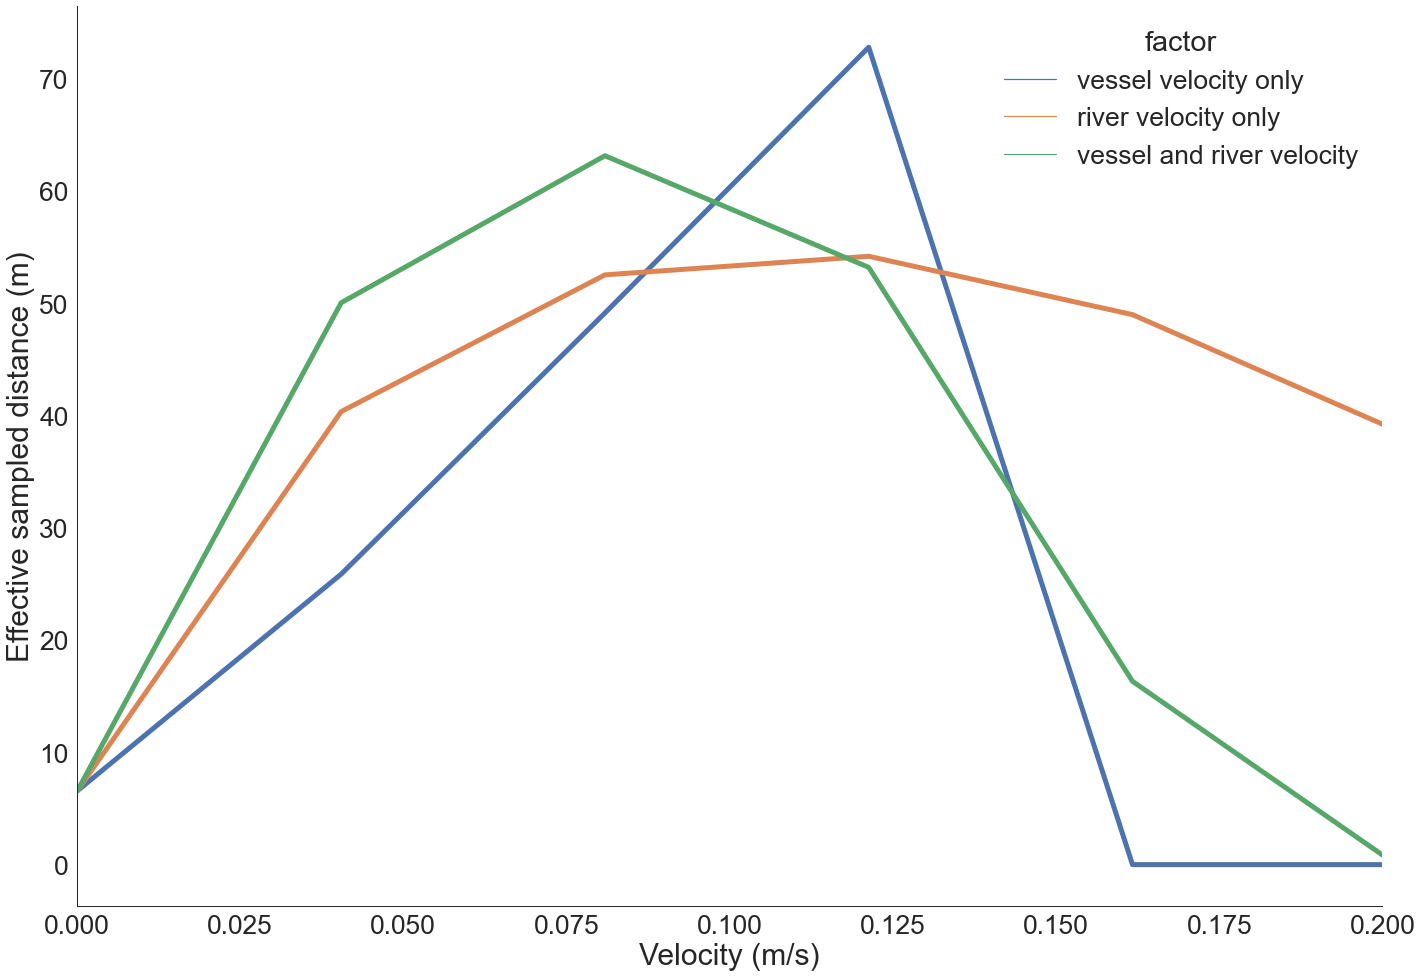

In [383]:
sns.lineplot(data = lg, x = 'velocity', y= 'length', hue='factor', linewidth = 5)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Effective sampled distance (m)')
sns.despine()
#plt.ylim([-.1, 50])
plt.xlim([-0.0, .2])

In [317]:
1e-4

0.0001

In [127]:
river = River()
river.init_fish(dist_bet_fish = 400, biomass = .03)
river.init_river_params(V =0, D = 1e-3,u = 1e7/60 , λ = 2e-3)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17


Wall time: 437 ms
Wall time: 333 ms


Text(0, 0.5, 'frequency')

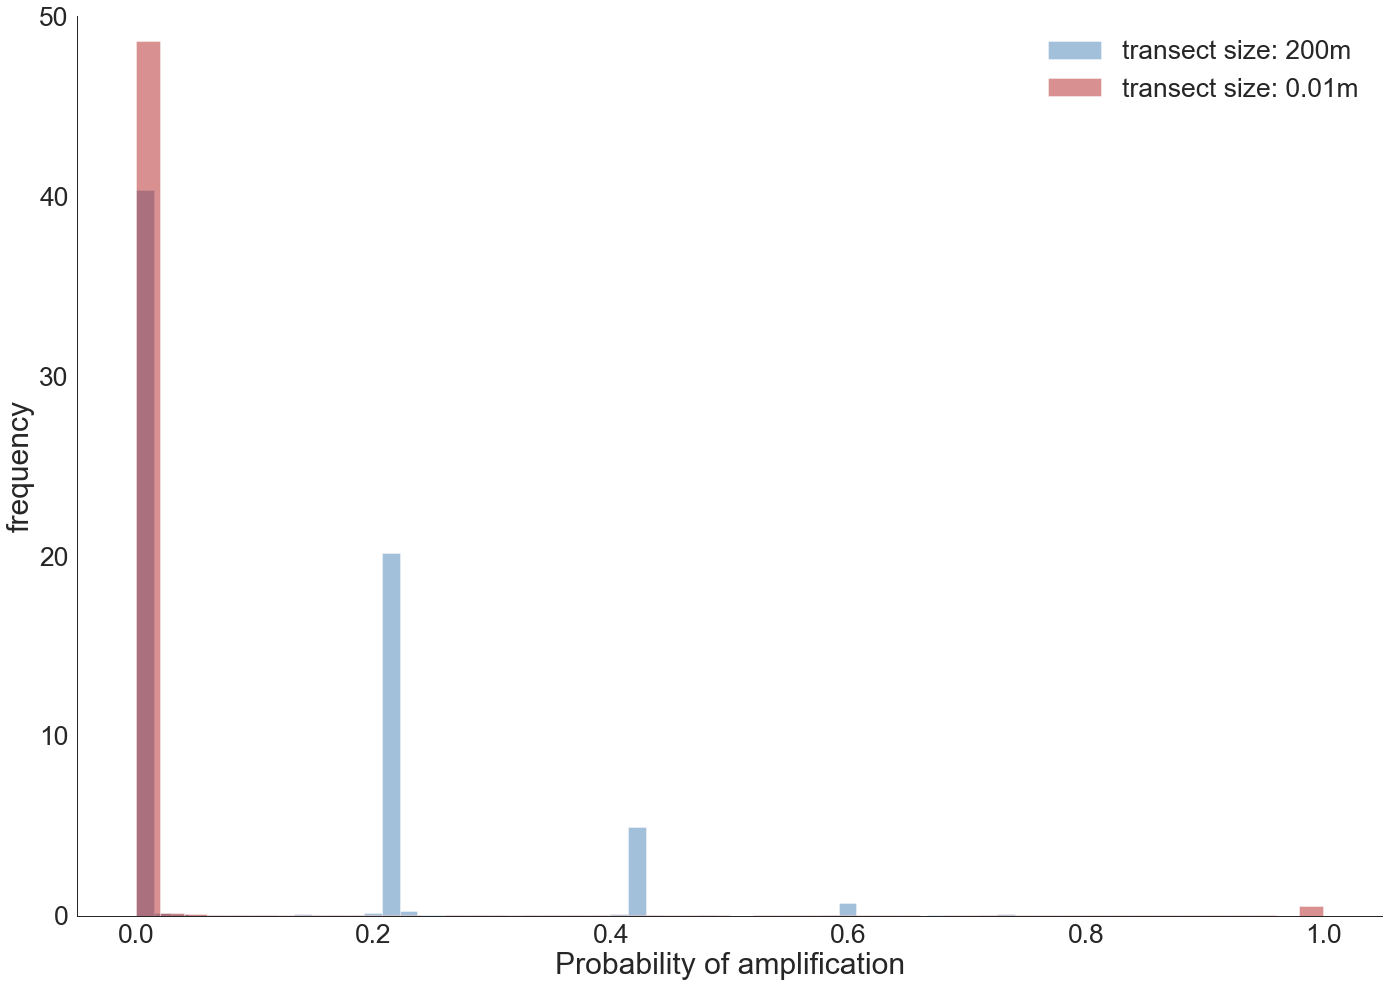

In [128]:
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
%time plt.hist(river.CtoP([river.sample_eDNA_transect_n_sources() for x in range(10000)]), bins = 50, density = 1, label = 'transect size: {:.0f}m'.format(river.BV*river.T), alpha =.5,  color = 'steelblue')
sns.despine()
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1e-5, time = 10*60)
%time plt.hist(river.CtoP([river.sample_eDNA_transect_n_sources() for x in range(10000)]), bins = 50, density = 1,  label = 'transect size: {:.2f}m'.format(river.BV*river.T), alpha =.5,  color = 'firebrick')

#plt.title('Probability of detection distribution for discrete sampling if fishes are on average {:.1f}m apart'.format(river.dist))
plt.legend()
plt.xlabel('Probability of amplification')
plt.ylim([0,50])
plt.ylabel('frequency')

In [126]:
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
a = river.CtoP([river.sample_eDNA_transect_n_sources() for x in range(10000)]
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1e-5, time = 10*60)
b = river.CtoP([river.sample_eDNA_transect_n_sources() for x in range(10000)]


%time plt.hist(river.CtoP([river.sample_eDNA_transect_n_sources() for x in range(10000)]), bins = 50, density = 1,histtype = 'barstacked',  label = 'transect size: {:.2f}m'.format(river.BV*river.T), alpha =.5,  color = 'firebrick')
sns.despine()
plt.title('Probability of detection distribution for discrete sampling \n if fishes are on average {:.1f}m apart'.format(river.dist))
plt.legend()
plt.xlabel('Probability of amplification')
plt.ylim([0,])
plt.ylabel('frequency')

SyntaxError: invalid syntax (<ipython-input-126-b19a15813fdb>, line 3)

In [142]:
river = River()
river.init_fish(dist_bet_fish = 400, biomass = .03)
river.init_river_params(V =0, D = 1e-3,u = 1e7/60 , λ = 2e-3)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.CtoP(river.sample_eDNA_transect_n_sources())[0]

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17


0.22176415984367126

In [226]:
%%time
river = River()
sma = []
bv_space = [1e-5/6, 50/600, 500/600] # np.array([1e-5, 0.05, .5])
fdist_space =  [10, 50, 250] #np.array([1e-5, .1, .3])
for bv,Dis in product(bv_space, fdist_space):
    for qwe in range(1000):
        river.init_river_params(V =1e-5, D = 1e-3,u = 1e7/60 , λ = 2e-3)
        river.init_fish(dist_bet_fish = Dis, biomass = .03)
        river.init_sampling_strategy(pf= 5*1e-3, boat_V= bv, time = 10*60)
        sma += [[Dis, bv*river.T,river.CtoP(river.sample_eDNA_transect_n_sources())[0]]]

    #sma += [[V, bv, river.sup + river.BV*river.T, river.inf]]
lg =pd.DataFrame(sma, columns = ['Distance between fish', 'transect length', 'Probability'])
#lg['group'] = lg.apply(lambda row: 'Adv: {:.2f}; Boat_V: {:.2f}'.format(row['Advection'], row['Boat speed']), axis = 1)
#lg['space'] = lg.apply(lambda row: list(range(int(row['inf']), int(row['sup']))), axis = 1)
#lg['length'] = lg.sup -lg.inf
#lg = lg.sort_values(['Advection', 'Boat speed'], ascending = False)

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17
Wall time: 20.1 s


In [227]:
lg

Distance between fish  transect length   Probability
0                        10            0.001  7.623677e-01
1                        10            0.001  1.000000e+00
2                        10            0.001  8.454831e-01
3                        10            0.001  7.657887e-01
4                        10            0.001  4.194934e-09
...                     ...              ...           ...
8995                    250          500.000  0.000000e+00
8996                    250          500.000  2.645935e-01
8997                    250          500.000  2.537156e-01
8998                    250          500.000  8.969674e-02
8999                    250          500.000  1.782502e-01

[9000 rows x 3 columns]

Text(0, 0.5, 'Frequency')

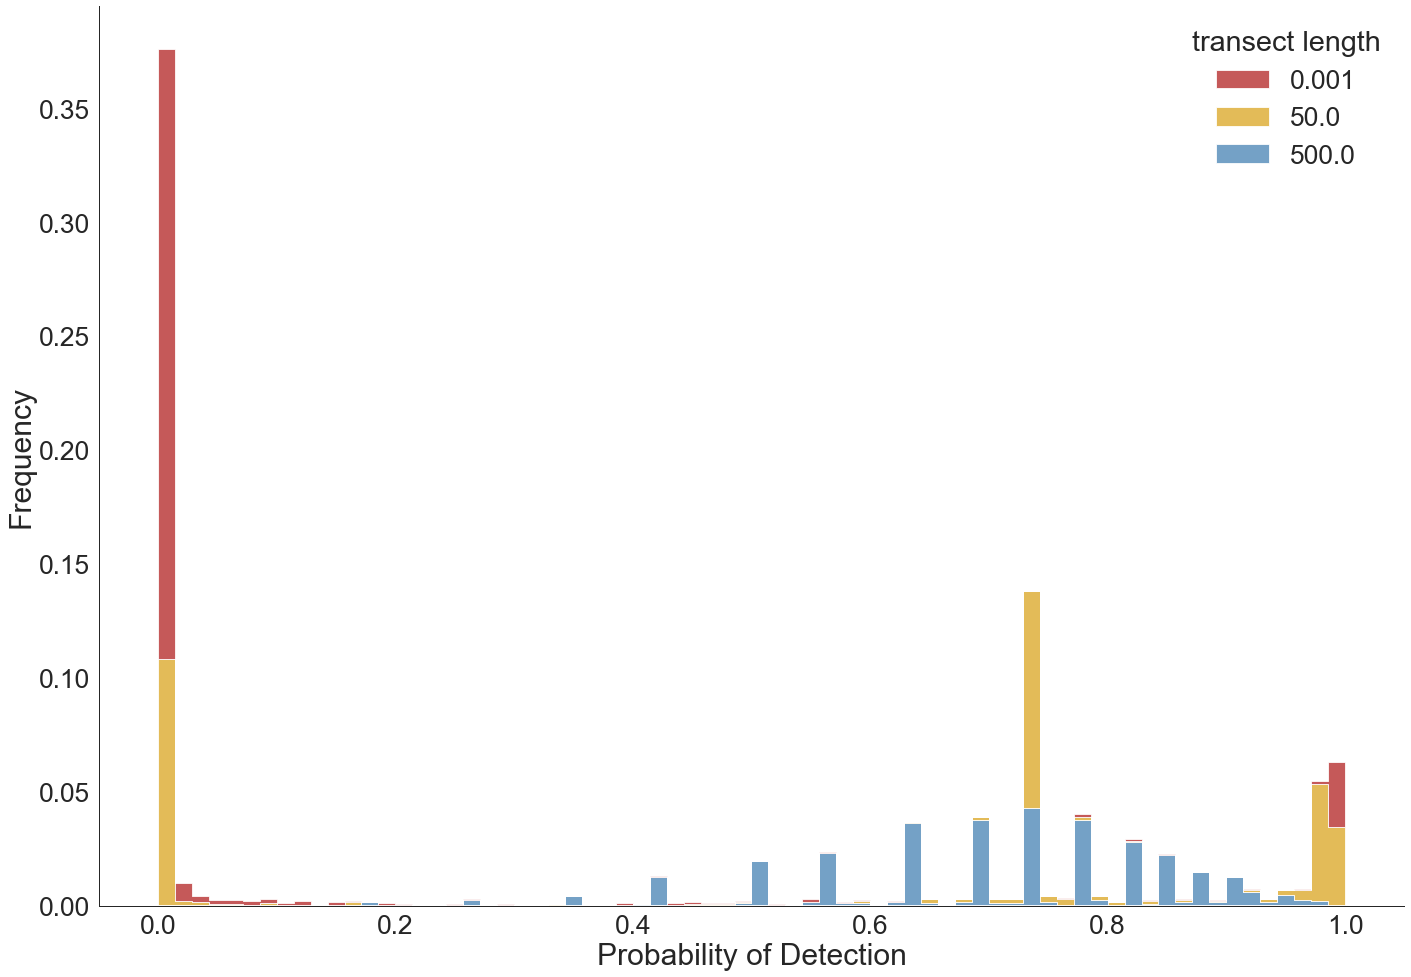

In [240]:
sns.histplot( hue = 'transect length', x = 'Probability',  data = lg[lg['Distance between fish']== 50],  element="step",multiple="stack",
             palette =['firebrick', 'goldenrod', 'steelblue'], stat = 'probability', bins = 70) #y = 'Distance between fish',cumulative=True
sns.despine()
plt.xlabel('Probability of Detection')
plt.ylabel('Frequency')

No handles with labels found to put in legend.


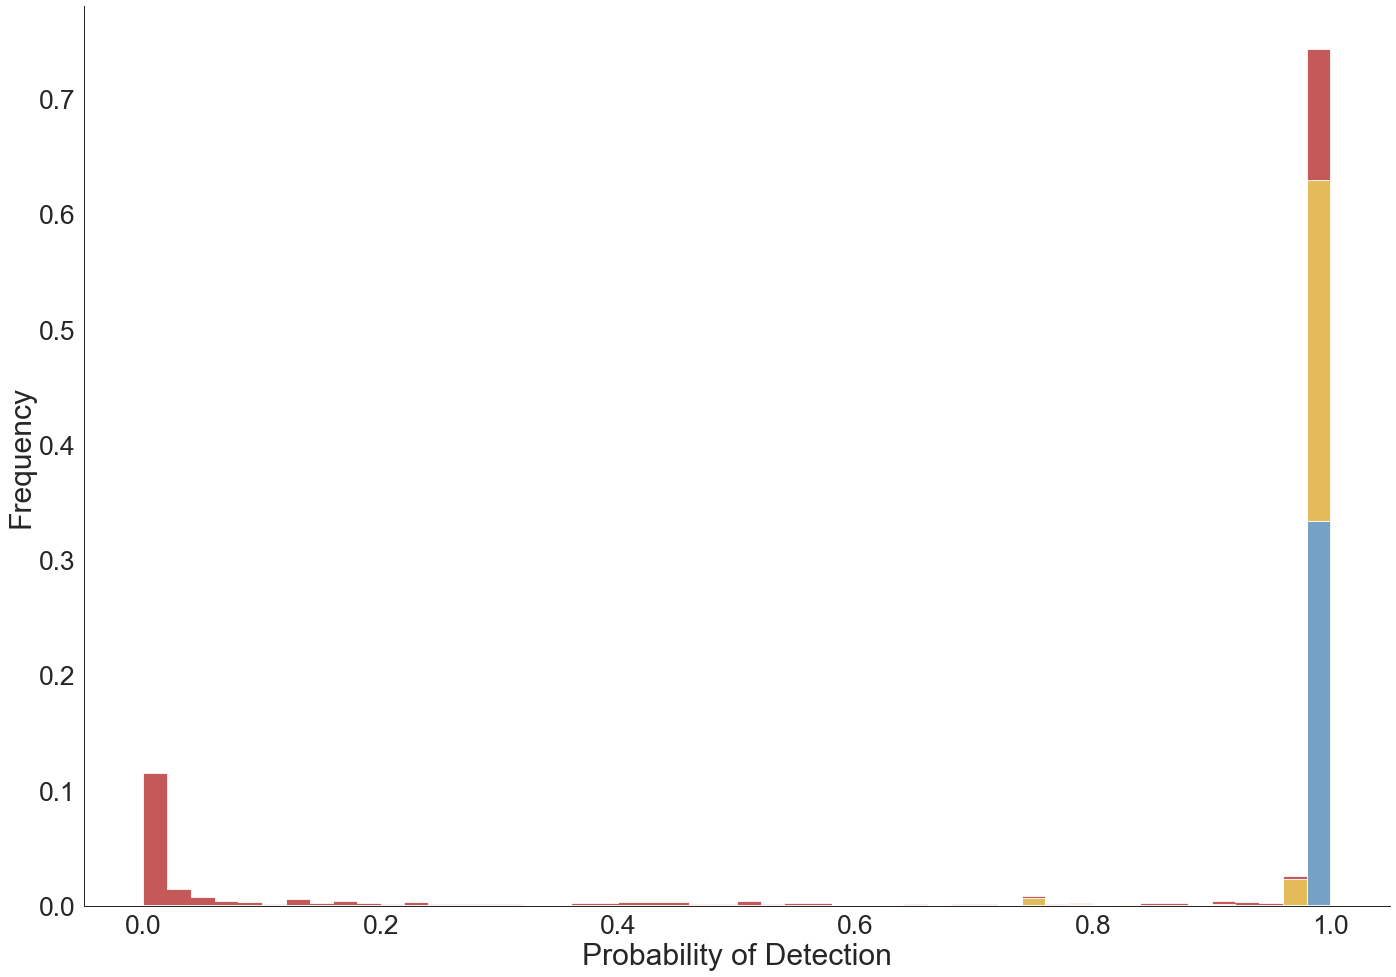

In [229]:
sns.histplot( hue = 'transect length', x = 'Probability',  data = lg[lg['Distance between fish']== 10],  element="step",multiple="stack",
             palette =['firebrick', 'goldenrod', 'steelblue'], stat = 'probability', bins = 70) #y = 'Distance between fish',cumulative=True
sns.despine()
plt.xlabel('Probability of Detection')
plt.ylabel('Frequency')
plt.legend(loc ='best')

No handles with labels found to put in legend.


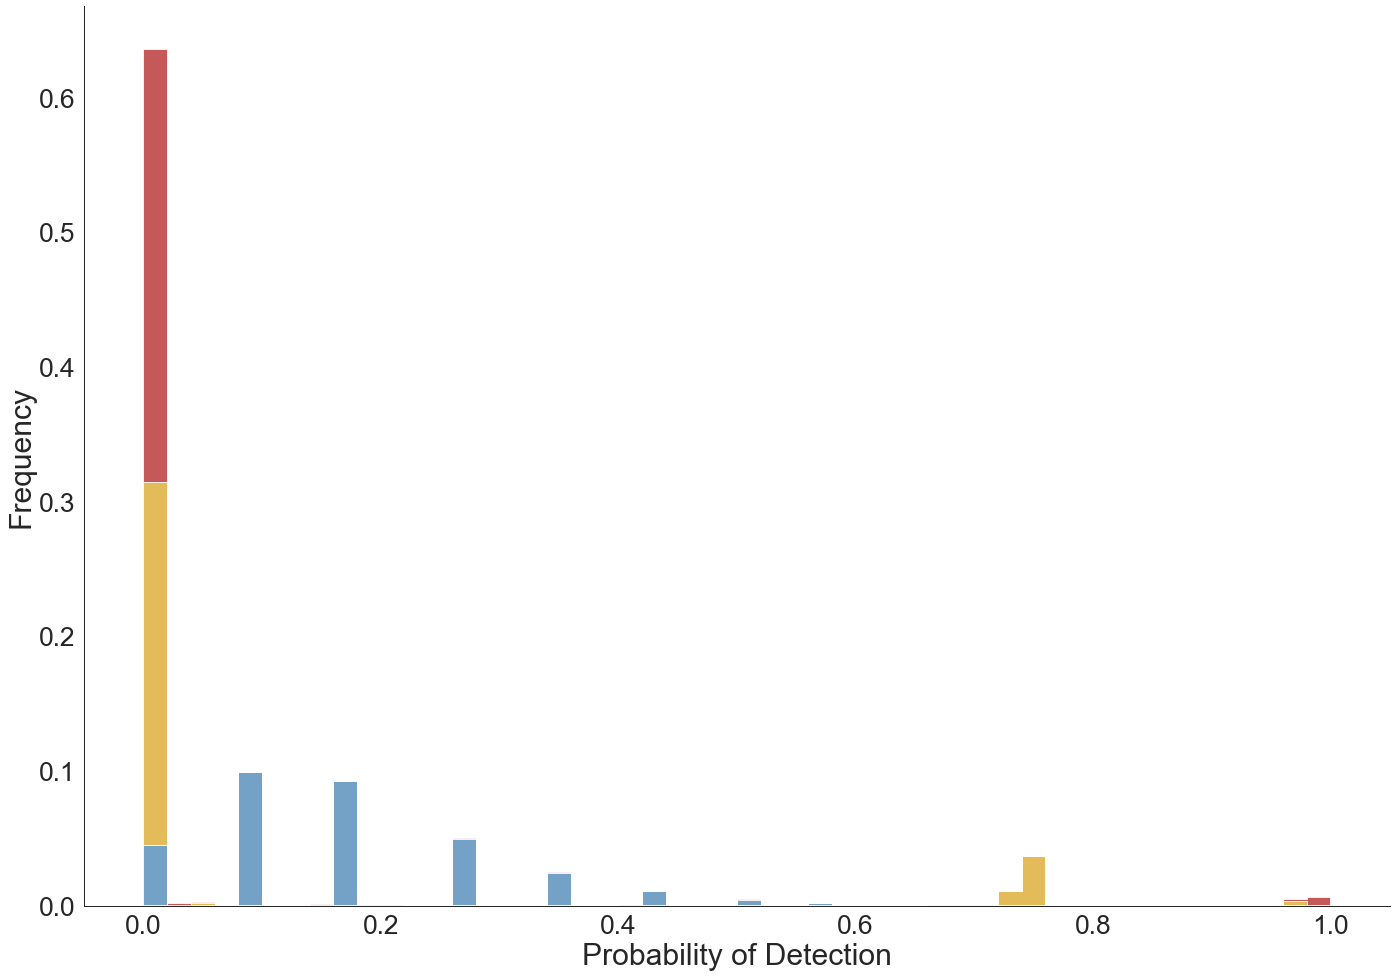

In [230]:
sns.histplot( hue = 'transect length', x = 'Probability',  data = lg[lg['Distance between fish']== 250],  element="step",multiple="stack",
             palette =['firebrick', 'goldenrod', 'steelblue'], stat = 'probability', bins = 70) #y = 'Distance between fish',cumulative=True
sns.despine()
plt.xlabel('Probability of Detection')
plt.ylabel('Frequency')
plt.legend(loc ='best')

In [248]:
1000/600*3.6/1.6

3.75

In [55]:
from scipy.optimize import curve_fit
def func_test(x, a, b):
    return 1 /(1+np.exp(-(a*x +b)))

curve_fit(func_test,ydata= probfunction['probability of amplification'],xdata=  probfunction['copy number'] )

(array([  1.        , -10.82077755]),
 array([[ 1.23824260e+31, -4.51977344e+27],
        [-4.51977344e+27,  1.64978591e+24]]))